# Pytorch Rals-C-SAGAN
* Ra - Relativistic Average;
* Ls - Least Squares;
* C - Conditional;
* SA - Self-Attention;
* DCGAN - Deep Convolutional Generative Adversarial Network

<br>
References:
* https://www.kaggle.com/speedwagon/ralsgan-dogs
* https://www.kaggle.com/cdeotte/dog-breed-cgan
* https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cgan/cgan.py
* https://github.com/voletiv/self-attention-GAN-pytorch/blob/master/sagan_models.py

In [2]:
# loss_calculation = 'hinge'
loss_calculation = 'rals'
batch_size = 32
crop_dog = True #犬のアノテーションを使用するかどうか
noisy_label = True #ラベルスムージング的な
R_uni = (0.85, 0.95) #ラベルスムージングするときのrealの範囲
F_uni = (0.05, 0.15) #ラベルスムージングするときのfakeの範囲
Gcbn = False # generatorにConditionalBatchNorm2dを使うかどうか
Glrelu = False # generatorにLeakyLeLUを使うかどうか
flip_p = 0.0 # RandomHorizontalFlipの割合
n_epochs = 301

use_pixelnorm = False
test_mode = True # commit時はFalseにしてinternetをoffにする
colapse_thre = 0.5 # modecolapseのしきい値

use_Gattn = True
use_Dattn = True

# optimizerゾーン
# G_opt = 'adaboundw'
G_opt = 'adam'
G_lr = 0.0002
G_betas = (0.5, 0.999) #ada系のみ
G_final_lr=0.5 # adaboundのみ
G_weight_decay=5e-4 # adaboundのみ
G_eta_min = 0.0003 # コサインアニーリングのパラメタ

# D_opt = 'adaboundw'
D_opt = 'adam'
# D_opt = 'SGD'
D_lr = 0.0002
D_betas = (0.5, 0.999) #ada系のみ
D_final_lr=0.1 # adaboundのみ
D_weight_decay=0 #adaboundのみ
D_eta_min = 0.0003

In [3]:
import requests
import datetime
import io
import os

import matplotlib.pyplot as plt

def notify(messages, files=None):
    url = "https://notify-api.line.me/api/notify"
    token = 'bVQ1eoiM1a8NuLwpw6iRRwnvPruRjRpjWMilh0D8E36'
    headers = {"Authorization" : "Bearer "+ token}
    payload = {"message" :  messages}

    r = requests.post(url ,headers = headers ,params=payload,files=files)

In [4]:
import os
import PIL
import torchvision
import torchvision.datasets as dset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import xml.etree.ElementTree as ET
import numpy as np

import imgaug as ia
import imgaug.augmenters as iaa

import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.nn.init import xavier_uniform_


import time
import torch
import torch.nn as nn

import torch.nn.parallel
import torch.optim as optim
from torch.nn.utils import spectral_norm
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.image as mpimg

import torch.nn.functional as F
from torch.nn import Parameter


import numpy as np
import os
import gzip, pickle
import tensorflow as tf
from scipy import linalg
import pathlib
import urllib
import warnings
from tqdm import tqdm
from PIL import Image
import zipfile

from tqdm import tqdm_notebook as tqdm
torch.backends.cudnn.deterministic = True

kernel_start_time = time.perf_counter()

# Helper Blocks

In [5]:
import math
import torch
from torch.optim import Optimizer


class AdaBound(Optimizer):
    """Implements AdaBound algorithm.
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBound, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBound, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                p.data.add_(-step_size)

        return loss

class AdaBoundW(Optimizer):
    """Implements AdaBound algorithm with Decoupled Weight Decay (arxiv.org/abs/1711.05101)
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBoundW, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBoundW, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                if group['weight_decay'] != 0:
                    decayed_weights = torch.mul(p.data, group['weight_decay'])
                    p.data.add_(-step_size)
                    p.data.sub_(decayed_weights)
                else:
                    p.data.add_(-step_size)

        return loss

In [6]:
# スペクトラルノルム使ったコンボそう
def snconv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
    return spectral_norm(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias))
# スペクトラルノルム使った全結合層
def snlinear(in_features, out_features):
    return spectral_norm(nn.Linear(in_features=in_features, out_features=out_features))

#スペクトラルノルム使ったエンべ層
def sn_embedding(num_embeddings, embedding_dim):
    return spectral_norm(nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim))

#カーネルのアテンションクラス
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_channels):
        super(Self_Attn, self).__init__()
        self.in_channels = in_channels
        self.snconv1x1_theta = snconv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_phi = snconv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_g = snconv2d(in_channels=in_channels, out_channels=in_channels//2, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_attn = snconv2d(in_channels=in_channels//2, out_channels=in_channels, kernel_size=1, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(2, stride=2, padding=0)
        self.softmax  = nn.Softmax(dim=-1)
        self.sigma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        _, ch, h, w = x.size()
        # Theta path
        theta = self.snconv1x1_theta(x)
        theta = theta.view(-1, ch//8, h*w)
        # Phi path
        phi = self.snconv1x1_phi(x)
        phi = self.maxpool(phi)
        phi = phi.view(-1, ch//8, h*w//4)
        # Attn map
        attn = torch.bmm(theta.permute(0, 2, 1), phi)
        attn = self.softmax(attn)
        # g path
        g = self.snconv1x1_g(x)
        g = self.maxpool(g)
        g = g.view(-1, ch//2, h*w//4)
        # Attn_g
        attn_g = torch.bmm(g, attn.permute(0, 2, 1))
        attn_g = attn_g.view(-1, ch//2, h, w)
        attn_g = self.snconv1x1_attn(attn_g)
        # Out
        out = x + self.sigma * attn_g
        return out

    
class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features)
        self.embed = nn.Embedding(num_classes, num_features * 2)
        self.embed.weight.data[:, :num_features].fill_(1.)  # Initialize scale to 1
        self.embed.weight.data[:, num_features:].zero_()    # Initialize bias at 0

    def forward(self, inputs):
        x, y = inputs
        
        out = self.bn(x)
        gamma, beta = self.embed(y).chunk(2, 1)
        out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        return out

# Generator and Discriminator

In [7]:
class UpConvBlock(nn.Module):
    """
    n_cl クラス数(120),
    k_s=カーネルサイズ(4), 
    stride=stride(2), 
    padding=padding(0), 
    bias=バイアス入れるかどうか（False),
    dropout_p=dropout_p(0.0), 
    use_cbn=Conditional Batch Normalization使うかどうか(True)
    Lrelu=LeakyReLU使うかどうか(True)(FalseはReLU)
    slope=Lreluのslope(0.05)
    """
    def __init__(self, n_input, n_output, n_cl, k_s=4, stride=2, padding=0, 
                 bias=False, dropout_p=0.0, use_cbn=True, Lrelu=True, slope=0.05):
        super(UpConvBlock, self).__init__()
        self.use_cbn = use_cbn
        self.dropout_p=dropout_p
        self.upconv = spectral_norm(nn.ConvTranspose2d(n_input, n_output, kernel_size=k_s, stride=stride, padding=padding, bias=bias))
        if use_cbn:
            self.cond_bn = ConditionalBatchNorm2d(n_output, n_cl)
        else: 
            self.bn = nn.BatchNorm2d(n_output)
        if Lrelu:
            self.activ = nn.LeakyReLU(slope, inplace=True)
        else:
            self.activ = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=dropout_p)
        
    def forward(self, inputs):
        x0, labels = inputs
        
        x = self.upconv(x0)
        if self.use_cbn: 
            x = self.activ(self.cond_bn((x, labels)))
        else:            
            x = self.activ(self.bn(x))
        if self.dropout_p > 0.0: 
            x = self.dropout(x)
        return x


class Generator(nn.Module):
    def __init__(self, nz=128, num_classes=120, channels=3, nfilt=64,use_cbn=True, Lrelu=True):
        super(Generator, self).__init__()
        self.nz = nz
        self.num_classes = num_classes
        self.channels = channels
        
        self.label_emb = nn.Embedding(num_classes, nz)
        self.upconv1 = UpConvBlock(2*nz, nfilt*8, num_classes, k_s=4, stride=1, padding=0, use_cbn=use_cbn,Lrelu=Lrelu) #4*4
        self.upconv2 = UpConvBlock(nfilt*8, nfilt*4, num_classes, k_s=4, stride=2, padding=1,use_cbn=use_cbn,Lrelu=Lrelu) #8*8 
        self.upconv3 = UpConvBlock(nfilt*4, nfilt*2, num_classes, k_s=4, stride=2, padding=1,use_cbn=use_cbn,Lrelu=Lrelu) # 16*16
        self.upconv4 = UpConvBlock(nfilt*2, nfilt, num_classes, k_s=4, stride=2, padding=1, use_cbn=use_cbn,Lrelu=Lrelu) #32*32
        self.upconv5 = UpConvBlock(nfilt, 3, num_classes, k_s=4, stride=2, padding=1, use_cbn=use_cbn,Lrelu=Lrelu) 
        if use_Gattn:
            self.self_attn = Self_Attn(nfilt)
        self.out_conv = spectral_norm(nn.Conv2d(3, 3, 3, 1, 1, bias=False))
        self.out_activ = nn.Tanh()
        
    def forward(self, inputs):
        z, labels = inputs
        
        enc = self.label_emb(labels).view((-1, self.nz, 1, 1))
        enc = F.normalize(enc, p=2, dim=1)
        x = torch.cat((z, enc), 1)
        
        x = self.upconv1((x, labels))
        x = self.upconv2((x, labels))
        x = self.upconv3((x, labels))
        x = self.upconv4((x, labels))
        if use_Gattn:
            x = self.self_attn(x)
        x = self.upconv5((x, labels))
        x = self.out_conv(x)
        img = self.out_activ(x)              
        return img
    
    
class Discriminator(nn.Module):
    def __init__(self, num_classes=120, channels=3, nfilt=64):
        super(Discriminator, self).__init__()
        self.channels = channels
        self.num_classes = num_classes

        def down_convlayer(n_input, n_output, k_s=4, stride=2, padding=0, dropout_p=0.0):
            block = [spectral_norm(nn.Conv2d(n_input, n_output, kernel_size=k_s, stride=stride, padding=padding, bias=False)),
                     nn.BatchNorm2d(n_output),
                     nn.LeakyReLU(0.2, inplace=True),
                    ]
            if dropout_p > 0.0: block.append(nn.Dropout(p=dropout_p))
            return block
        
        self.label_emb = nn.Embedding(num_classes, 64*64)
        if use_Dattn:
            self.model = nn.Sequential(
                *down_convlayer(self.channels + 1, nfilt, 4, 2, 1), 
                Self_Attn(nfilt),                            
                *down_convlayer(nfilt, nfilt*2, 4, 2, 1),
                *down_convlayer(nfilt*2, nfilt*4, 4, 2, 1),
                *down_convlayer(nfilt*4, nfilt*8, 4, 2, 1),
                spectral_norm(nn.Conv2d(nfilt*8, 1, 4, 1, 0, bias=False)),
            )

        else:
            self.model = nn.Sequential(
                *down_convlayer(self.channels + 1, nfilt, 4, 2, 1),            
                *down_convlayer(nfilt, nfilt*2, 4, 2, 1),
                *down_convlayer(nfilt*2, nfilt*4, 4, 2, 1),
                *down_convlayer(nfilt*4, nfilt*8, 4, 2, 1),
                spectral_norm(nn.Conv2d(nfilt*8, 1, 4, 1, 0, bias=False)),
            )

    def forward(self, inputs):
        imgs, labels = inputs

        enc = self.label_emb(labels).view((-1, 1, 64, 64))
        enc = F.normalize(enc, p=2, dim=1)
        x = torch.cat((imgs, enc), 1)   # 4 input feature maps(3rgb + 1label)
        
        out = self.model(x)
        return out.view(-1)

    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constrideant_(m.bias.data, 0)

# Data loader

In [8]:
class DataGenerator(Dataset):
    def __init__(self, directory, transform=None, n_samples=np.inf, crop_dogs=True):
        self.directory = directory
        self.transform = transform
        self.n_samples = n_samples        
        self.samples, self.labels = self.load_dogs_data(directory, crop_dogs)

    def load_dogs_data(self, directory, crop_dogs):
        required_transforms = torchvision.transforms.Compose([
                torchvision.transforms.Resize(64),
                torchvision.transforms.CenterCrop(64),
        ])

        imgs = []
        labels = []
        paths = []
        for root, _, fnames in sorted(os.walk(directory)):
            for fname in sorted(fnames)[:min(self.n_samples, 999999999999999)]:
                path = os.path.join(root, fname)
                paths.append(path)

        for path in paths:
            # Load image
            try: img = dset.folder.default_loader(path)
            except: continue
            
            # Get bounding boxes
            annotation_basename = os.path.splitext(os.path.basename(path))[0]
            annotation_dirname = next(
                    dirname for dirname in os.listdir('../input/annotation/Annotation/') if
                    dirname.startswith(annotation_basename.split('_')[0]))
                
            if crop_dogs:
                tree = ET.parse(os.path.join('../input/annotation/Annotation/',
                                             annotation_dirname, annotation_basename))
                root = tree.getroot()
                objects = root.findall('object')
                for o in objects:
                    bndbox = o.find('bndbox')
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)
                    object_img = required_transforms(img.crop((xmin, ymin, xmax, ymax)))
                    imgs.append(object_img)
                    labels.append(annotation_dirname.split('-')[1].lower())

            else:
                object_img = required_transforms(img)
                imgs.append(object_img)
                labels.append(annotation_dirname.split('-')[1].lower())
            
        return imgs, labels
    
    
    def __getitem__(self, index):
        sample = self.samples[index]
        label = self.labels[index]
        
        if self.transform is not None: 
            sample = self.transform(sample)
        return np.asarray(sample), label

    
    def __len__(self):
        return len(self.samples)

## Training Parameters

In [9]:
database = '../input/all-dogs/all-dogs/'
crop_dogs = crop_dog
n_samples = np.inf
BATCH_SIZE = batch_size

epochs = n_epochs

use_soft_noisy_labels=noisy_label #ラベルスムージングするかどうか
loss_calc = loss_calculation

nz = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([transforms.RandomHorizontalFlip(p=flip_p),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = DataGenerator(database, transform=transform, n_samples=n_samples, crop_dogs=crop_dogs)

decoded_dog_labels = {i:breed for i, breed in enumerate(sorted(set(train_data.labels)))}
encoded_dog_labels = {breed:i for i, breed in enumerate(sorted(set(train_data.labels)))}
train_data.labels = [encoded_dog_labels[l] for l in train_data.labels] # encode dog labels in the data generator


train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=BATCH_SIZE, num_workers=4)


print("Dog breeds loaded:  ", len(encoded_dog_labels))
print("Data samples loaded:", len(train_data))

Dog breeds loaded:   120
Data samples loaded: 22125


In [10]:
netG = Generator(nz, num_classes=len(encoded_dog_labels), nfilt=64,use_cbn=Gcbn, Lrelu=Glrelu).to(device)
netD = Discriminator(num_classes=len(encoded_dog_labels), nfilt=64).to(device)
weights_init(netG)
weights_init(netD)
print("Generator parameters:    ", sum(p.numel() for p in netG.parameters() if p.requires_grad))
print("Discriminator parameters:", sum(p.numel() for p in netD.parameters() if p.requires_grad))

if G_opt == 'adaboundw':
    optimizerG = AdaBoundW(netG.parameters(), lr=G_lr, betas=G_betas,final_lr=G_final_lr,weight_decay=G_weight_decay)
elif G_opt == 'adam':
    optimizerG = optim.Adam(netG.parameters(), lr=G_lr, betas=G_betas)
    
if D_opt == 'adaboundw':
    optimizerD = AdaBoundW(netD.parameters(), lr=D_lr, betas=D_betas,final_lr=D_final_lr,weight_decay=D_weight_decay)
elif D_opt == 'adam':
    optimizerD = optim.Adam(netD.parameters(), lr=D_lr, betas=D_betas)
elif D_opt == 'SGD':
    optimizerD = optim.SGD(netD.parameters(), lr=D_lr)

# lr_schedulerG = torch.optim.lr_scheduler.ExponentialLR(optimizerG, gamma=.99)
# lr_schedulerD = torch.optim.lr_scheduler.ExponentialLR(optimizerD, gamma=.99)

lr_schedulerG = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerG, T_0=epochs//20, eta_min=G_eta_min)
lr_schedulerD = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerD, T_0=epochs//20, eta_min=D_eta_min)

Generator parameters:     4875336
Discriminator parameters: 3263473


In [11]:
def mse(imageA, imageB):
        err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
        err /= float(imageA.shape[0] * imageA.shape[1])
        return err

def show_generated_img(n_images=5, nz=128):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        dog_label = torch.randint(0, len(encoded_dog_labels), (1, ), device=device)
        gen_image = netG((noise, dog_label)).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
        
    figure, axes = plt.subplots(1, len(sample), figsize=(64, 64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = (sample[index] + 1.) / 2.
        axis.imshow(image_array)
    plt.show()
    
    return image_array

    
def analyse_generated_by_class(n_images=5):
    good_breeds = []
    for l in range(len(decoded_dog_labels)):
        sample = []
        for _ in range(n_images):
            noise = torch.randn(1, nz, 1, 1, device=device)
            dog_label = torch.full((1,) , l, device=device, dtype=torch.long)
            gen_image = netG((noise, dog_label)).to("cpu").clone().detach().squeeze(0)
            gen_image = gen_image.numpy().transpose(1, 2, 0)
            sample.append(gen_image)
        
        d = np.round(np.sum([mse(sample[k], sample[k+1]) for k in range(len(sample)-1)])/n_images, 1)
        
        if l % 10 == 0:            
            print(f"Generated breed({d}): ", decoded_dog_labels[l])
            figure, axes = plt.subplots(1, len(sample), figsize=(64, 64))
            for index, axis in enumerate(axes):
                axis.axis('off')
                image_array = (sample[index] + 1.) / 2.
                axis.imshow(image_array)
            plt.show()
        if d < colapse_thre:
            print(f"colapse_breed({d}): ", decoded_dog_labels[l])
            continue  # had mode colapse(discard)
        good_breeds.append(l)           
        
    return good_breeds


def create_submit(good_breeds):
    print("Creating submit")
    os.makedirs('../output_images', exist_ok=True)
    im_batch_size = 100
    n_images = 10000
    
    all_dog_labels = np.random.choice(good_breeds, size=n_images, replace=True)
    for i_batch in range(0, n_images, im_batch_size):
        dog_labels = torch.from_numpy(all_dog_labels[i_batch: (i_batch+im_batch_size)]).to(device)
        noise = torch.randn(im_batch_size, nz, 1, 1, device=device)
        gen_images = netG((noise, dog_labels))
        gen_images = (gen_images.to("cpu").clone().detach() + 1) / 2
        for ii, img in enumerate(gen_images):
            save_image(gen_images[ii, :, :, :], os.path.join('../output_images', f'image_{i_batch + ii:05d}.png'))
            
    import shutil
    shutil.make_archive('images', 'zip', '../output_images')

## Training loop

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


loss=rals 1epochの中での平均値 
 59.48s [1/301] Loss_D: 0.1579 Loss_G: 3.5217 outputR: -1.2444 outputF: -2.0210 / -2.2128
  最後のバッチのloss等 
    59.49s [1/301] Loss_D: 0.2092 Loss_G: 3.6020 outputR: -2.0325 outputF: -2.5293 / -3.0612


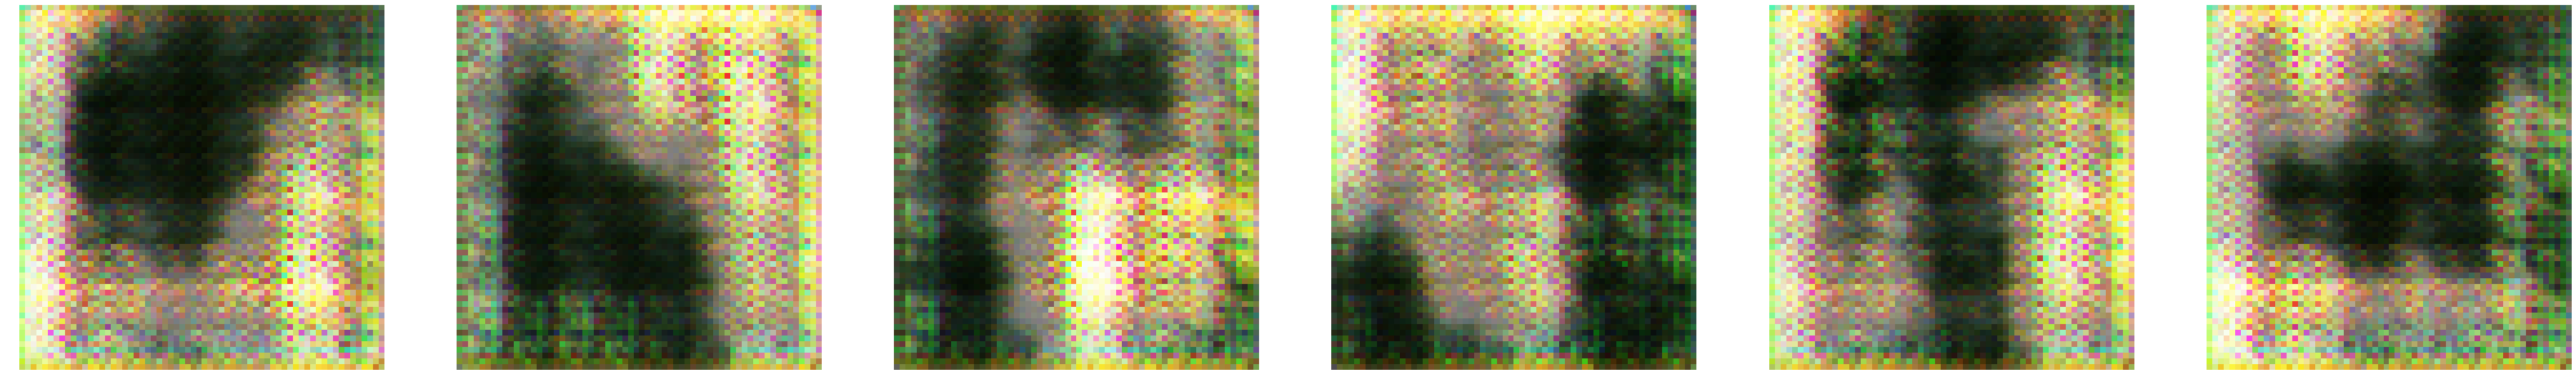

loss=rals 1epochの中での平均値 
 58.75s [2/301] Loss_D: 0.1691 Loss_G: 3.5596 outputR: -2.1120 outputF: -2.8254 / -3.1004
  最後のバッチのloss等 
    58.75s [2/301] Loss_D: 0.0796 Loss_G: 3.8029 outputR: -0.8111 outputF: -1.6944 / -1.8575
loss=rals 1epochの中での平均値 
 58.60s [3/301] Loss_D: 0.1503 Loss_G: 3.2845 outputR: -1.5935 outputF: -2.3277 / -2.5171
  最後のバッチのloss等 
    58.61s [3/301] Loss_D: 0.1879 Loss_G: 3.0847 outputR: -1.2576 outputF: -2.4058 / -2.1660
loss=rals 1epochの中での平均値 
 58.50s [4/301] Loss_D: 0.1162 Loss_G: 3.0848 outputR: -1.4263 outputF: -2.1965 / -2.2999
  最後のバッチのloss等 
    58.50s [4/301] Loss_D: 0.0416 Loss_G: 2.6070 outputR: -0.9293 outputF: -1.6620 / -1.6441
loss=rals 1epochの中での平均値 
 58.23s [5/301] Loss_D: 0.1298 Loss_G: 3.2537 outputR: -1.0455 outputF: -1.7961 / -1.9630
  最後のバッチのloss等 
    58.23s [5/301] Loss_D: 0.4493 Loss_G: 3.0502 outputR: -0.7292 outputF: -1.1102 / -1.5558
loss=rals 1epochの中での平均値 
 58.24s [6/301] Loss_D: 0.1226 Loss_G: 3.3365 outputR: -0.6312 outputF: -1.3938

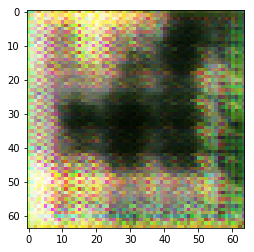

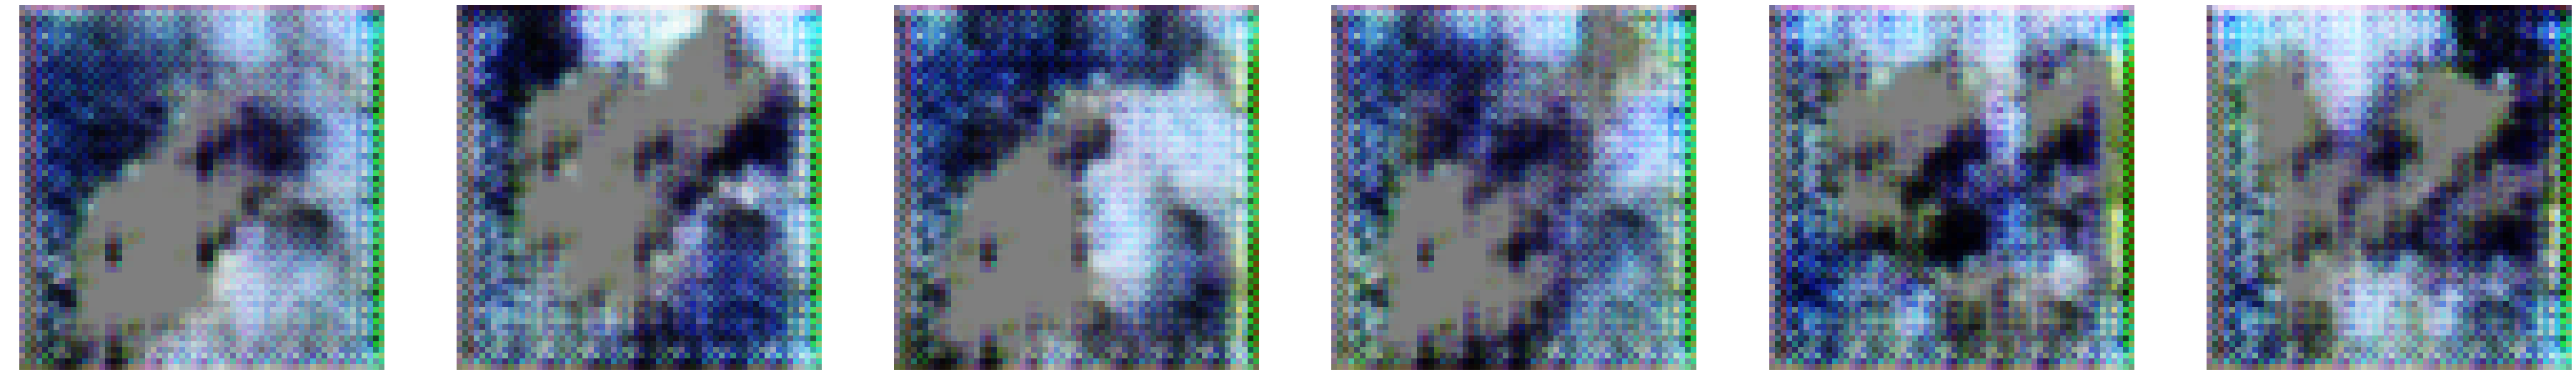

loss=rals 1epochの中での平均値 
 58.21s [12/301] Loss_D: 0.0484 Loss_G: 3.0417 outputR: 0.0717 outputF: -0.7732 / -0.7979
  最後のバッチのloss等 
    58.21s [12/301] Loss_D: 0.0043 Loss_G: 3.2822 outputR: -0.1186 outputF: -1.0319 / -1.0379
loss=rals 1epochの中での平均値 
 58.63s [13/301] Loss_D: 0.0681 Loss_G: 3.1560 outputR: 0.0298 outputF: -0.7906 / -0.8661
  最後のバッチのloss等 
    58.63s [13/301] Loss_D: 0.0737 Loss_G: 3.8805 outputR: 0.4646 outputF: -0.2000 / -0.6017
loss=rals 1epochの中での平均値 
 58.65s [14/301] Loss_D: 0.1205 Loss_G: 3.2734 outputR: -0.5112 outputF: -1.2701 / -1.4361
  最後のバッチのloss等 
    58.65s [14/301] Loss_D: 0.1228 Loss_G: 2.6349 outputR: -0.7899 outputF: -1.4027 / -1.5623
loss=rals 1epochの中での平均値 
 58.35s [15/301] Loss_D: 0.1037 Loss_G: 3.2206 outputR: -0.4904 outputF: -1.2686 / -1.4035
  最後のバッチのloss等 
    58.35s [15/301] Loss_D: 0.2084 Loss_G: 2.6635 outputR: 0.1297 outputF: -1.1178 / -0.6318
loss=rals 1epochの中での平均値 
 58.31s [16/301] Loss_D: 0.0693 Loss_G: 3.0647 outputR: -0.1403 outputF: -0

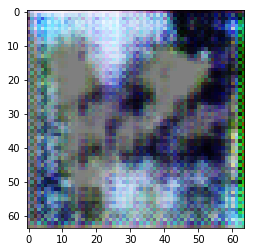

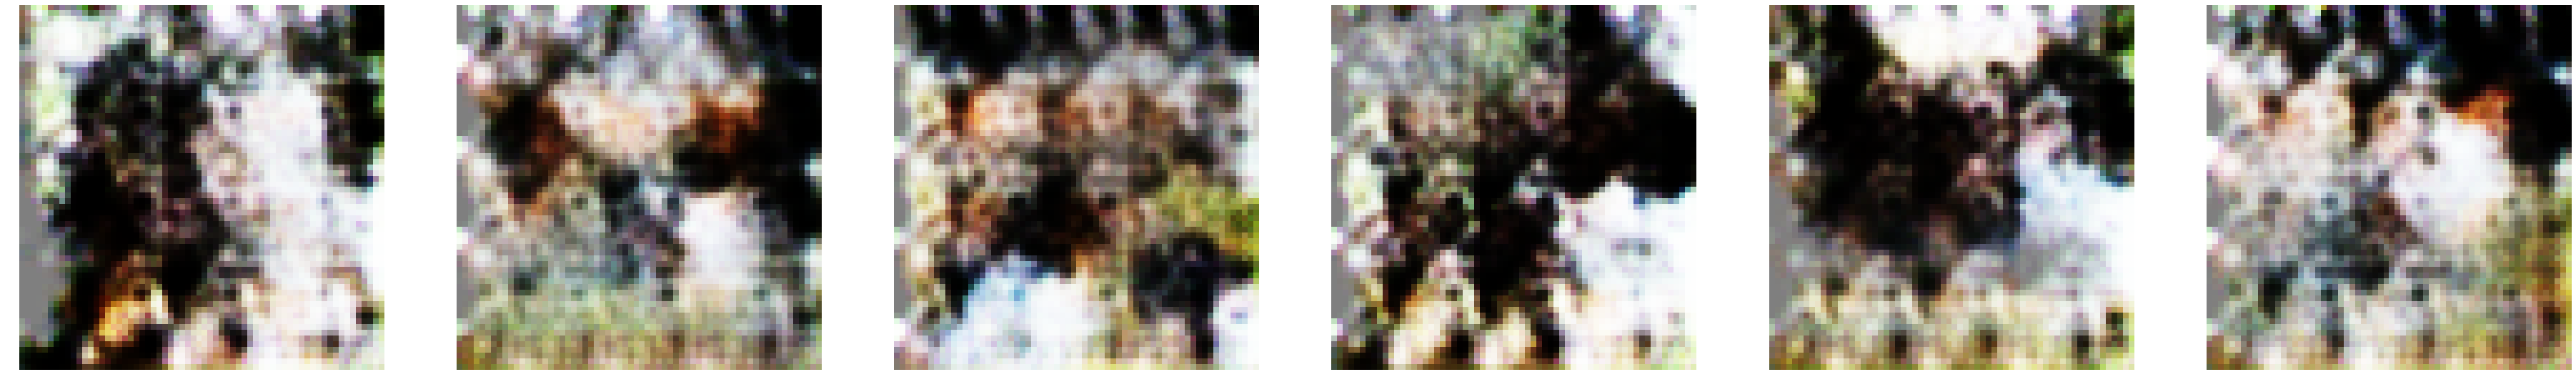

loss=rals 1epochの中での平均値 
 58.40s [22/301] Loss_D: 0.0821 Loss_G: 3.0818 outputR: -0.9040 outputF: -1.7055 / -1.7816
  最後のバッチのloss等 
    58.40s [22/301] Loss_D: 0.0719 Loss_G: 3.6438 outputR: -1.0694 outputF: -2.2123 / -2.0741
loss=rals 1epochの中での平均値 
 58.43s [23/301] Loss_D: 0.0797 Loss_G: 3.1229 outputR: -0.6378 outputF: -1.4464 / -1.5268
  最後のバッチのloss等 
    58.43s [23/301] Loss_D: 0.0101 Loss_G: 3.4148 outputR: -0.2064 outputF: -1.1074 / -1.1565
loss=rals 1epochの中での平均値 
 58.30s [24/301] Loss_D: 0.0747 Loss_G: 3.0735 outputR: -0.2681 outputF: -1.0824 / -1.1433
  最後のバッチのloss等 
    58.30s [24/301] Loss_D: 0.0579 Loss_G: 2.5456 outputR: -0.3486 outputF: -1.1071 / -1.0822
loss=rals 1epochの中での平均値 
 58.29s [25/301] Loss_D: 0.0779 Loss_G: 3.0362 outputR: -0.2150 outputF: -1.0251 / -1.0793
  最後のバッチのloss等 
    58.29s [25/301] Loss_D: 0.0090 Loss_G: 3.2671 outputR: -0.1218 outputF: -1.0766 / -1.0279
loss=rals 1epochの中での平均値 
 58.30s [26/301] Loss_D: 0.0670 Loss_G: 3.0760 outputR: 0.1277 outputF:

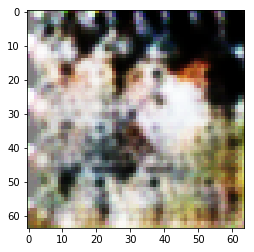

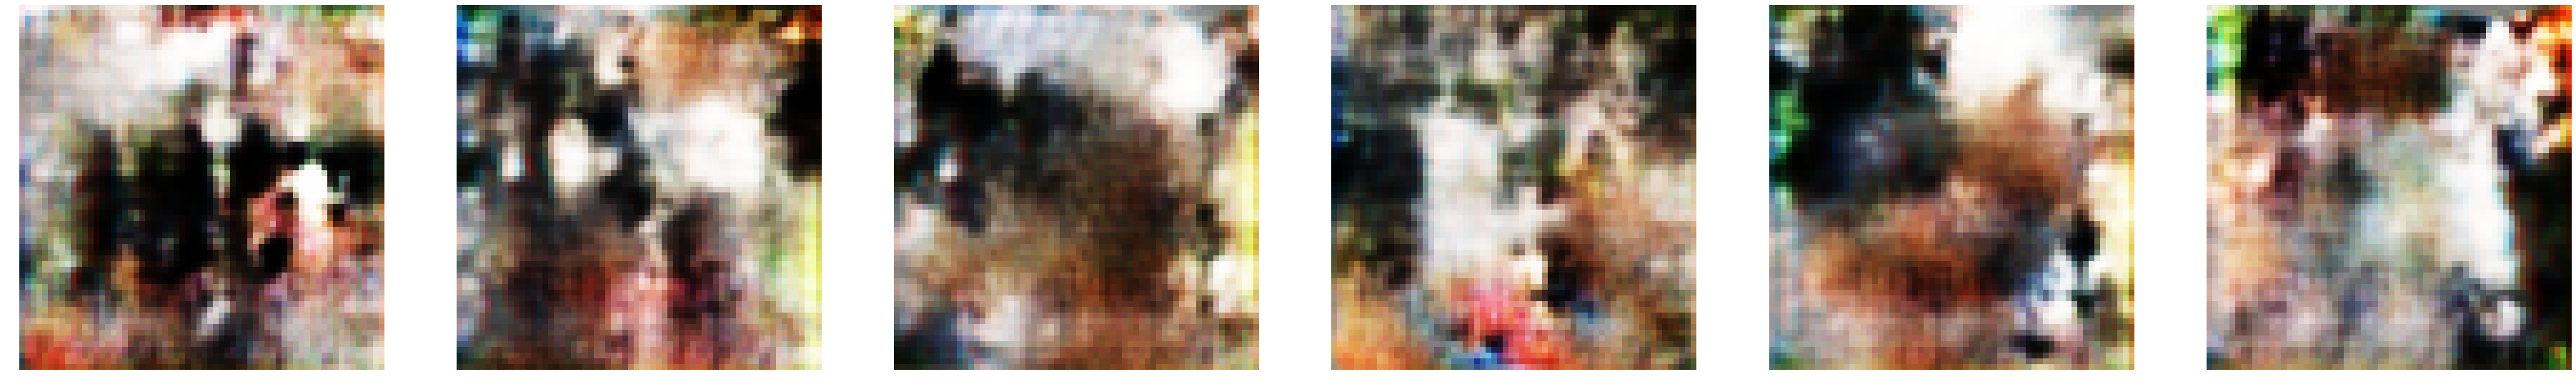

loss=rals 1epochの中での平均値 
 58.12s [32/301] Loss_D: 0.0835 Loss_G: 3.0524 outputR: -0.8906 outputF: -1.6866 / -1.7587
  最後のバッチのloss等 
    58.12s [32/301] Loss_D: 0.2890 Loss_G: 2.3260 outputR: -1.2435 outputF: -1.6187 / -1.8790
loss=rals 1epochの中での平均値 
 58.01s [33/301] Loss_D: 0.0808 Loss_G: 3.0417 outputR: -0.9342 outputF: -1.7366 / -1.8013
  最後のバッチのloss等 
    58.01s [33/301] Loss_D: 0.1180 Loss_G: 2.9991 outputR: -0.7824 outputF: -1.8360 / -1.6669
loss=rals 1epochの中での平均値 
 58.13s [34/301] Loss_D: 0.0804 Loss_G: 3.0423 outputR: -0.8775 outputF: -1.6799 / -1.7440
  最後のバッチのloss等 
    58.13s [34/301] Loss_D: 0.0836 Loss_G: 3.8672 outputR: -0.5167 outputF: -1.2382 / -1.6042
loss=rals 1epochの中での平均値 
 58.08s [35/301] Loss_D: 0.0770 Loss_G: 3.0755 outputR: -0.7738 outputF: -1.5825 / -1.6494
  最後のバッチのloss等 
    58.08s [35/301] Loss_D: 0.0321 Loss_G: 3.3397 outputR: -0.8019 outputF: -1.5786 / -1.7301
loss=rals 1epochの中での平均値 
 58.17s [36/301] Loss_D: 0.0754 Loss_G: 3.0717 outputR: -0.8748 outputF

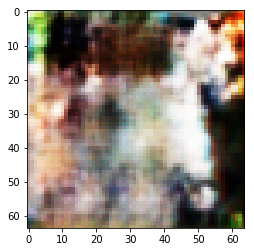

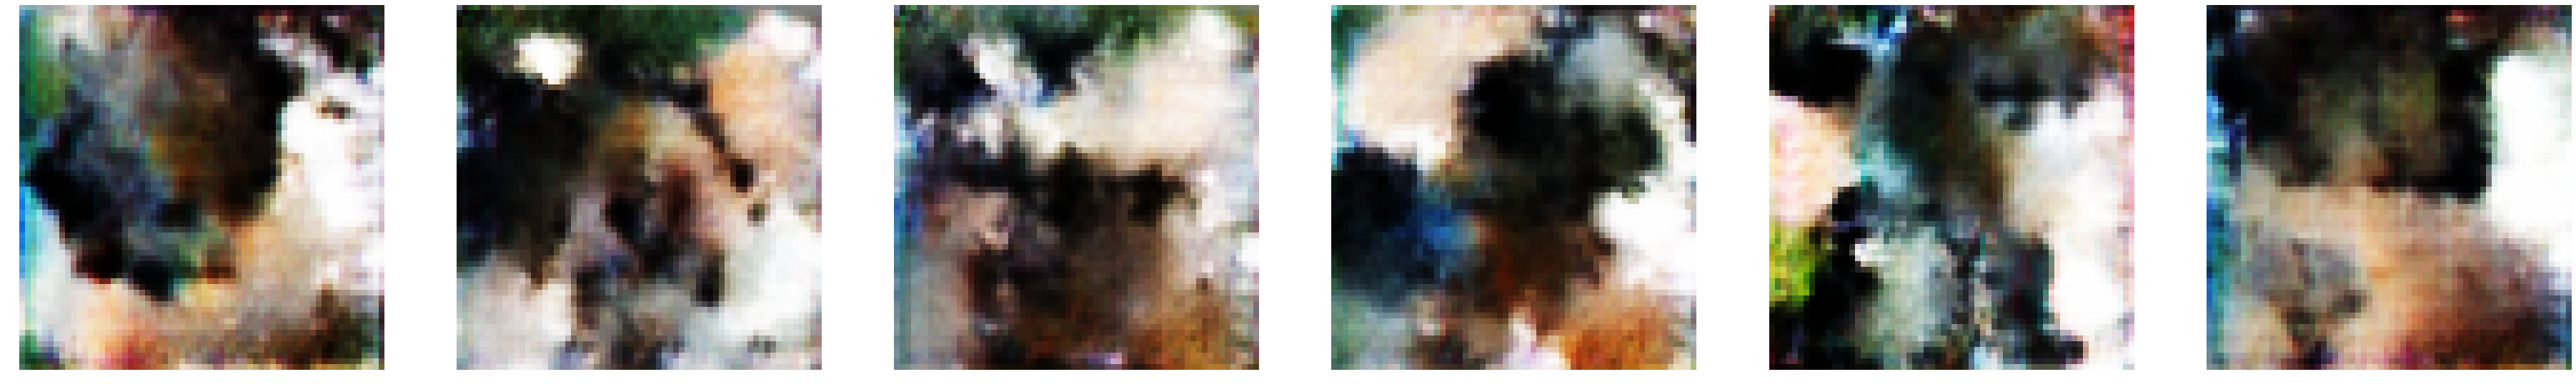

loss=rals 1epochの中での平均値 
 58.13s [42/301] Loss_D: 0.0708 Loss_G: 3.0978 outputR: -0.5383 outputF: -1.3545 / -1.4210
  最後のバッチのloss等 
    58.13s [42/301] Loss_D: 0.0336 Loss_G: 3.0956 outputR: -0.2656 outputF: -1.0978 / -1.1489
loss=rals 1epochの中での平均値 
 58.37s [43/301] Loss_D: 0.0695 Loss_G: 3.0854 outputR: -0.4899 outputF: -1.3062 / -1.3695
  最後のバッチのloss等 
    58.37s [43/301] Loss_D: 0.0126 Loss_G: 3.2315 outputR: -0.4364 outputF: -1.3683 / -1.3326
loss=rals 1epochの中での平均値 
 58.63s [44/301] Loss_D: 0.0746 Loss_G: 3.0661 outputR: -0.4492 outputF: -1.2609 / -1.3238
  最後のバッチのloss等 
    58.63s [44/301] Loss_D: 0.1513 Loss_G: 3.4172 outputR: -0.7105 outputF: -1.2455 / -1.6488
loss=rals 1epochの中での平均値 
 58.36s [45/301] Loss_D: 0.0737 Loss_G: 3.0858 outputR: -0.3471 outputF: -1.1602 / -1.2281
  最後のバッチのloss等 
    58.36s [45/301] Loss_D: 0.0700 Loss_G: 3.0078 outputR: -0.4050 outputF: -1.2988 / -1.2922
loss=rals 1epochの中での平均値 
 58.37s [46/301] Loss_D: 0.0615 Loss_G: 3.0370 outputR: -0.3562 outputF

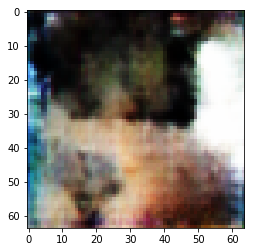

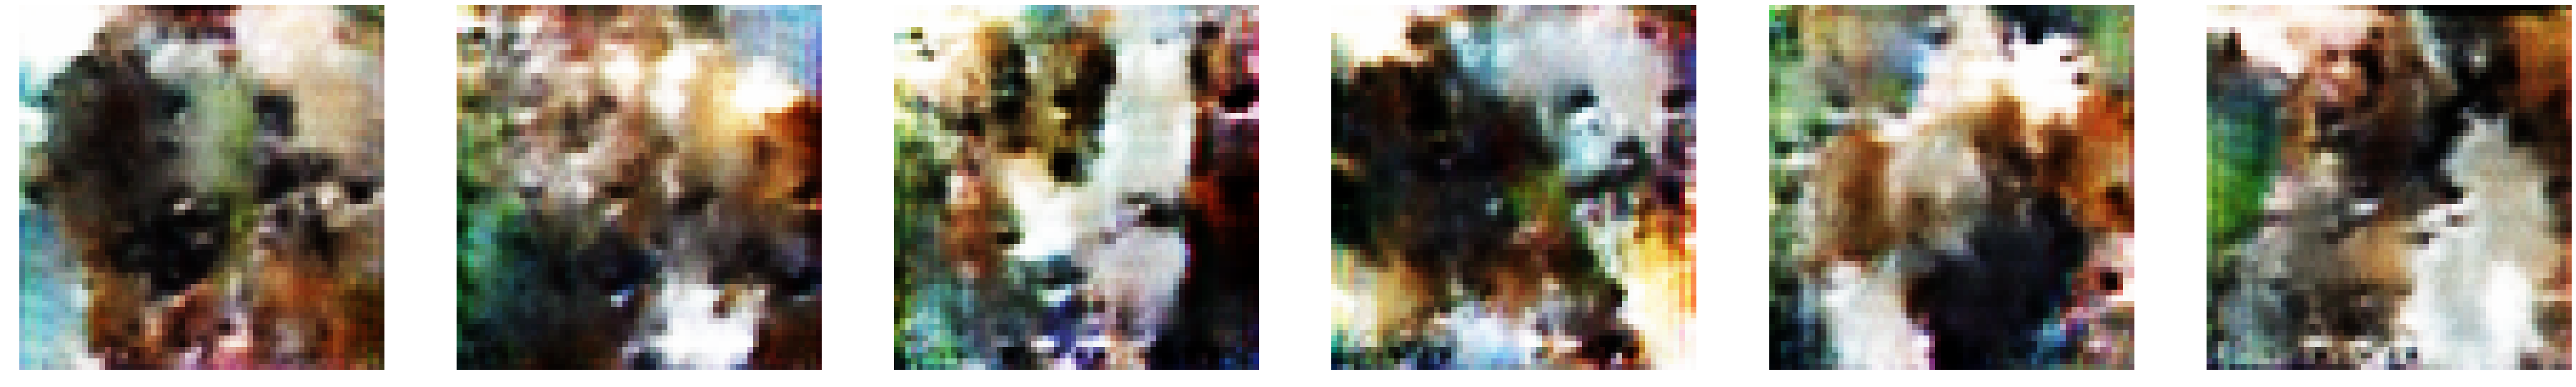

loss=rals 1epochの中での平均値 
 58.56s [52/301] Loss_D: 0.0653 Loss_G: 3.0537 outputR: -0.3030 outputF: -1.1244 / -1.1734
  最後のバッチのloss等 
    58.56s [52/301] Loss_D: 0.0168 Loss_G: 3.3205 outputR: -0.2509 outputF: -1.1192 / -1.1655
loss=rals 1epochの中での平均値 
 58.39s [53/301] Loss_D: 0.0659 Loss_G: 3.0635 outputR: -0.2809 outputF: -1.1023 / -1.1548
  最後のバッチのloss等 
    58.39s [53/301] Loss_D: 0.0365 Loss_G: 3.0114 outputR: -0.6080 outputF: -1.4181 / -1.4570
loss=rals 1epochの中での平均値 
 58.37s [54/301] Loss_D: 0.0683 Loss_G: 3.0687 outputR: -0.2720 outputF: -1.0879 / -1.1458
  最後のバッチのloss等 
    58.37s [54/301] Loss_D: 0.0643 Loss_G: 2.8387 outputR: -0.3841 outputF: -1.1503 / -1.2250
loss=rals 1epochの中での平均値 
 58.20s [55/301] Loss_D: 0.0742 Loss_G: 3.0718 outputR: -0.2807 outputF: -1.0909 / -1.1567
  最後のバッチのloss等 
    58.20s [55/301] Loss_D: 0.0587 Loss_G: 3.2111 outputR: -0.6839 outputF: -1.4414 / -1.5973
loss=rals 1epochの中での平均値 
 57.92s [56/301] Loss_D: 0.0715 Loss_G: 3.0687 outputR: -0.3059 outputF

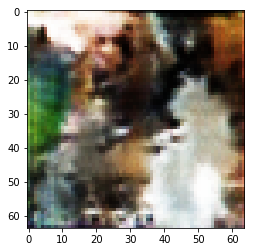

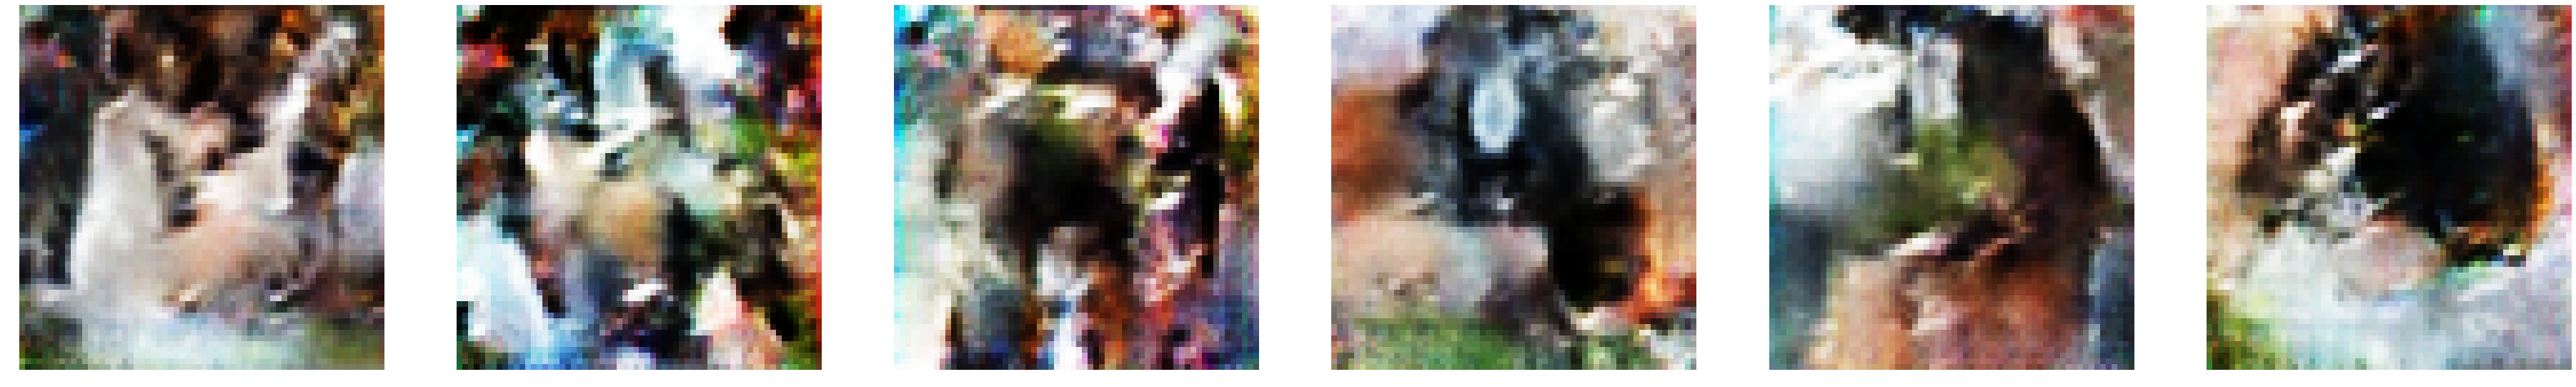

loss=rals 1epochの中での平均値 
 58.03s [62/301] Loss_D: 0.0649 Loss_G: 2.9920 outputR: -0.1316 outputF: -0.9511 / -0.9870
  最後のバッチのloss等 
    58.03s [62/301] Loss_D: 0.0313 Loss_G: 3.2329 outputR: -0.3027 outputF: -1.2097 / -1.2219
loss=rals 1epochの中での平均値 
 57.83s [63/301] Loss_D: 0.0623 Loss_G: 3.0423 outputR: -0.1463 outputF: -0.9696 / -1.0117
  最後のバッチのloss等 
    57.83s [63/301] Loss_D: 0.0835 Loss_G: 2.6074 outputR: -0.5156 outputF: -1.2155 / -1.2779
loss=rals 1epochの中での平均値 
 57.89s [64/301] Loss_D: 0.0650 Loss_G: 3.0047 outputR: -0.2363 outputF: -1.0580 / -1.0930
  最後のバッチのloss等 
    57.89s [64/301] Loss_D: 0.0560 Loss_G: 3.0508 outputR: -0.1673 outputF: -0.9879 / -1.0449
loss=rals 1epochの中での平均値 
 58.11s [65/301] Loss_D: 0.0612 Loss_G: 3.0301 outputR: -0.1642 outputF: -0.9894 / -1.0268
  最後のバッチのloss等 
    58.11s [65/301] Loss_D: 0.0113 Loss_G: 3.2524 outputR: 0.0251 outputF: -0.8798 / -0.8816
loss=rals 1epochの中での平均値 
 57.84s [66/301] Loss_D: 0.0677 Loss_G: 3.0235 outputR: -0.1654 outputF:

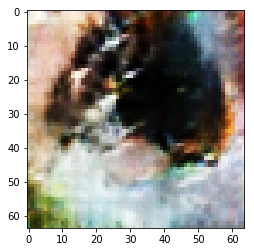

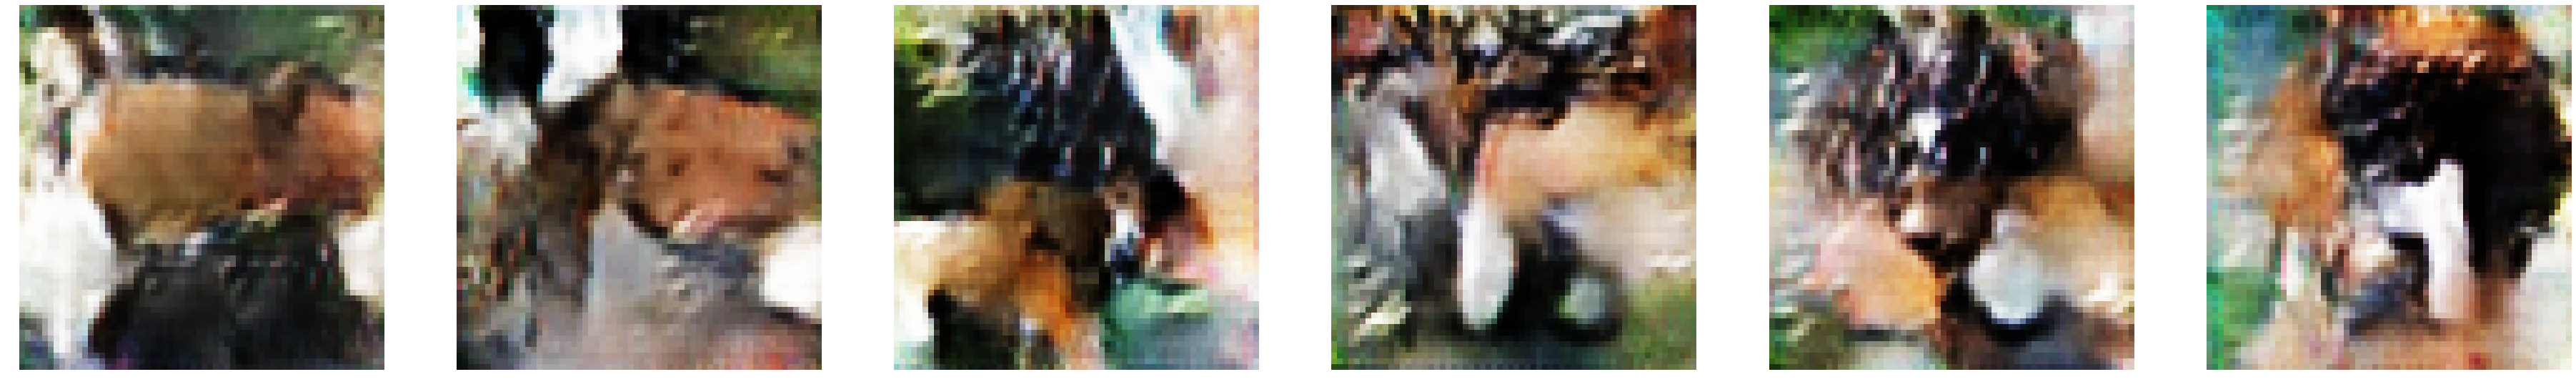

loss=rals 1epochの中での平均値 
 57.77s [72/301] Loss_D: 0.0703 Loss_G: 3.0347 outputR: -0.2005 outputF: -1.0168 / -1.0664
  最後のバッチのloss等 
    57.77s [72/301] Loss_D: 0.0550 Loss_G: 3.0481 outputR: 0.2257 outputF: -0.7974 / -0.6468
loss=rals 1epochの中での平均値 
 57.88s [73/301] Loss_D: 0.0694 Loss_G: 3.0297 outputR: -0.1149 outputF: -0.9312 / -0.9793
  最後のバッチのloss等 
    57.88s [73/301] Loss_D: 0.0735 Loss_G: 2.7274 outputR: -0.3756 outputF: -1.0552 / -1.1596
loss=rals 1epochの中での平均値 
 57.75s [74/301] Loss_D: 0.0709 Loss_G: 3.0470 outputR: -0.0564 outputF: -0.8716 / -0.9240
  最後のバッチのloss等 
    57.75s [74/301] Loss_D: 0.0608 Loss_G: 2.9091 outputR: 0.1195 outputF: -0.7461 / -0.7210
loss=rals 1epochの中での平均値 
 57.98s [75/301] Loss_D: 0.0688 Loss_G: 3.0415 outputR: -0.1056 outputF: -0.9238 / -0.9732
  最後のバッチのloss等 
    57.98s [75/301] Loss_D: 0.0895 Loss_G: 2.8208 outputR: -0.0452 outputF: -1.1035 / -0.8644
loss=rals 1epochの中での平均値 
 57.85s [76/301] Loss_D: 0.0591 Loss_G: 2.9913 outputR: -0.0967 outputF: 

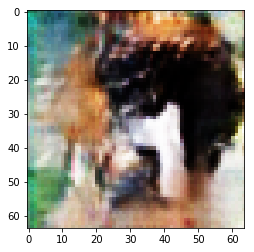

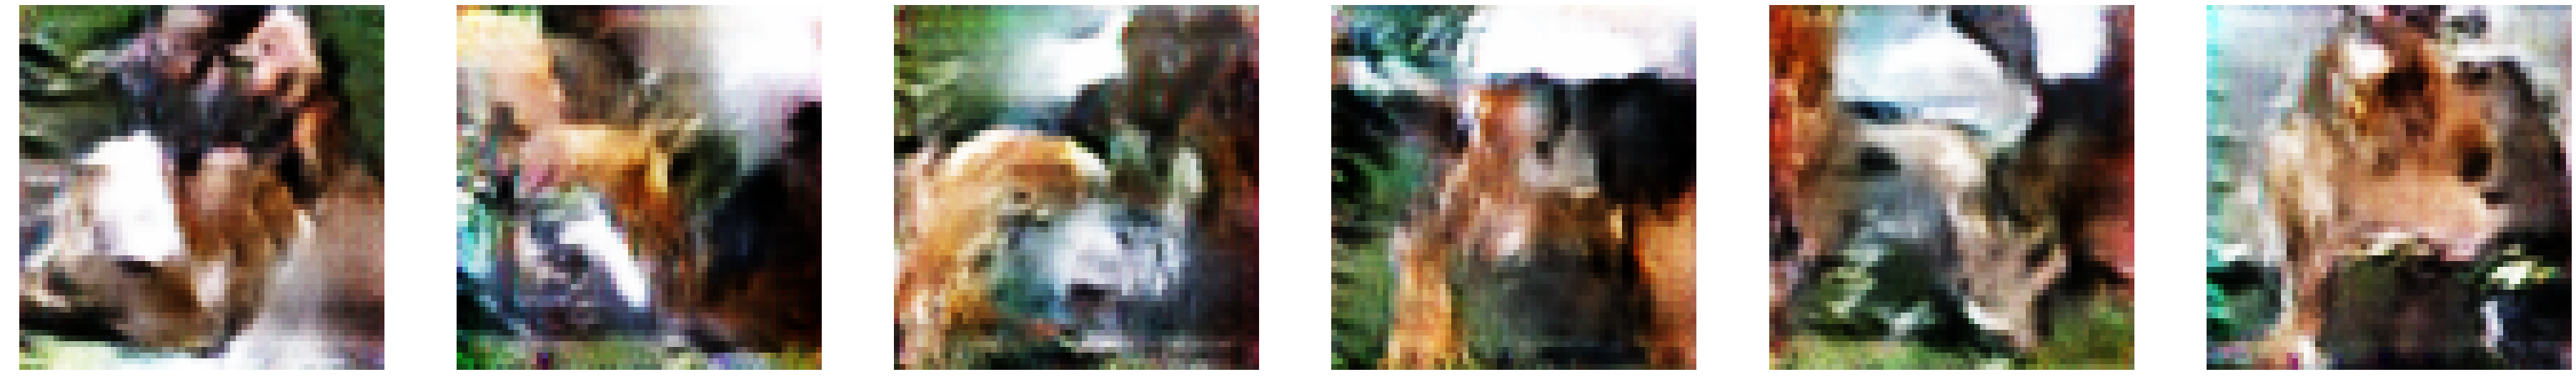

loss=rals 1epochの中での平均値 
 57.75s [82/301] Loss_D: 0.0624 Loss_G: 3.0210 outputR: -0.1405 outputF: -0.9657 / -1.0024
  最後のバッチのloss等 
    57.75s [82/301] Loss_D: 0.0278 Loss_G: 2.8237 outputR: -0.1495 outputF: -0.9461 / -0.9273
loss=rals 1epochの中での平均値 
 57.70s [83/301] Loss_D: 0.0610 Loss_G: 3.0330 outputR: -0.1697 outputF: -0.9969 / -1.0338
  最後のバッチのloss等 
    57.70s [83/301] Loss_D: 0.0884 Loss_G: 2.7428 outputR: -0.4365 outputF: -1.0929 / -1.2212
loss=rals 1epochの中での平均値 
 57.74s [84/301] Loss_D: 0.0646 Loss_G: 3.0199 outputR: -0.1469 outputF: -0.9698 / -1.0086
  最後のバッチのloss等 
    57.74s [84/301] Loss_D: 0.0312 Loss_G: 3.4113 outputR: -0.2683 outputF: -1.3133 / -1.2085
loss=rals 1epochの中での平均値 
 57.73s [85/301] Loss_D: 0.0651 Loss_G: 3.0307 outputR: -0.0741 outputF: -0.8963 / -0.9378
  最後のバッチのloss等 
    57.73s [85/301] Loss_D: 0.0462 Loss_G: 2.6362 outputR: -0.4869 outputF: -1.2186 / -1.2235
loss=rals 1epochの中での平均値 
 57.92s [86/301] Loss_D: 0.0643 Loss_G: 3.0249 outputR: -0.0843 outputF

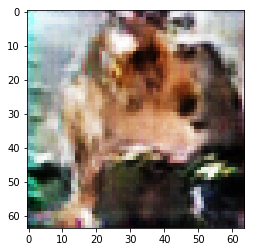

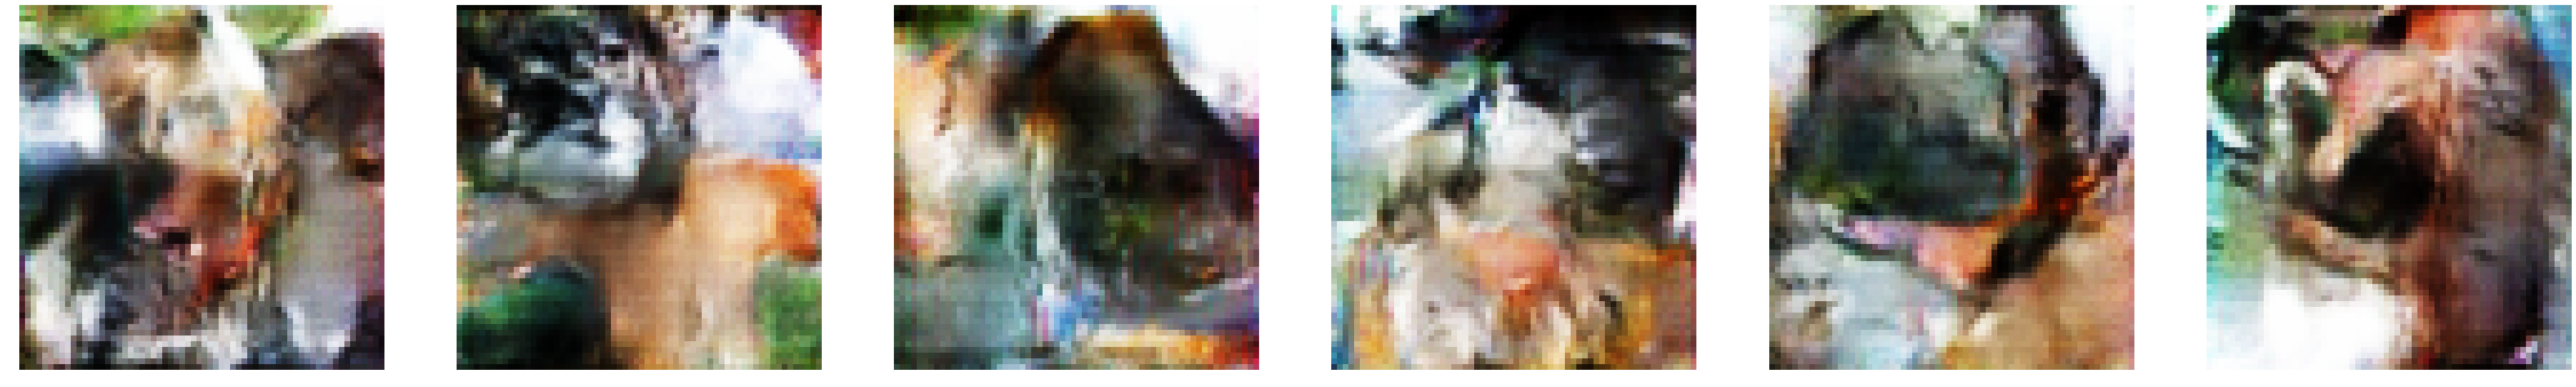

loss=rals 1epochの中での平均値 
 57.75s [92/301] Loss_D: 0.0559 Loss_G: 2.9917 outputR: -0.0549 outputF: -0.8844 / -0.9087
  最後のバッチのloss等 
    57.75s [92/301] Loss_D: 0.0616 Loss_G: 3.1668 outputR: -0.2258 outputF: -1.1545 / -1.1364
loss=rals 1epochの中での平均値 
 57.66s [93/301] Loss_D: 0.0588 Loss_G: 2.9913 outputR: -0.0839 outputF: -0.9119 / -0.9379
  最後のバッチのloss等 
    57.66s [93/301] Loss_D: 0.0227 Loss_G: 3.1453 outputR: 0.0910 outputF: -0.7676 / -0.7996
loss=rals 1epochの中での平均値 
 57.72s [94/301] Loss_D: 0.0593 Loss_G: 2.9990 outputR: -0.1184 outputF: -0.9465 / -0.9753
  最後のバッチのloss等 
    57.72s [94/301] Loss_D: 0.0265 Loss_G: 2.9724 outputR: -0.3363 outputF: -1.1723 / -1.1791
loss=rals 1epochの中での平均値 
 57.61s [95/301] Loss_D: 0.0600 Loss_G: 2.9949 outputR: -0.0748 outputF: -0.9011 / -0.9294
  最後のバッチのloss等 
    57.61s [95/301] Loss_D: 0.0358 Loss_G: 3.1955 outputR: -0.0815 outputF: -0.9278 / -0.9819
loss=rals 1epochの中での平均値 
 58.12s [96/301] Loss_D: 0.0593 Loss_G: 3.0115 outputR: -0.0570 outputF:

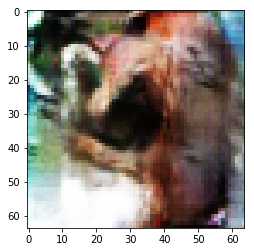

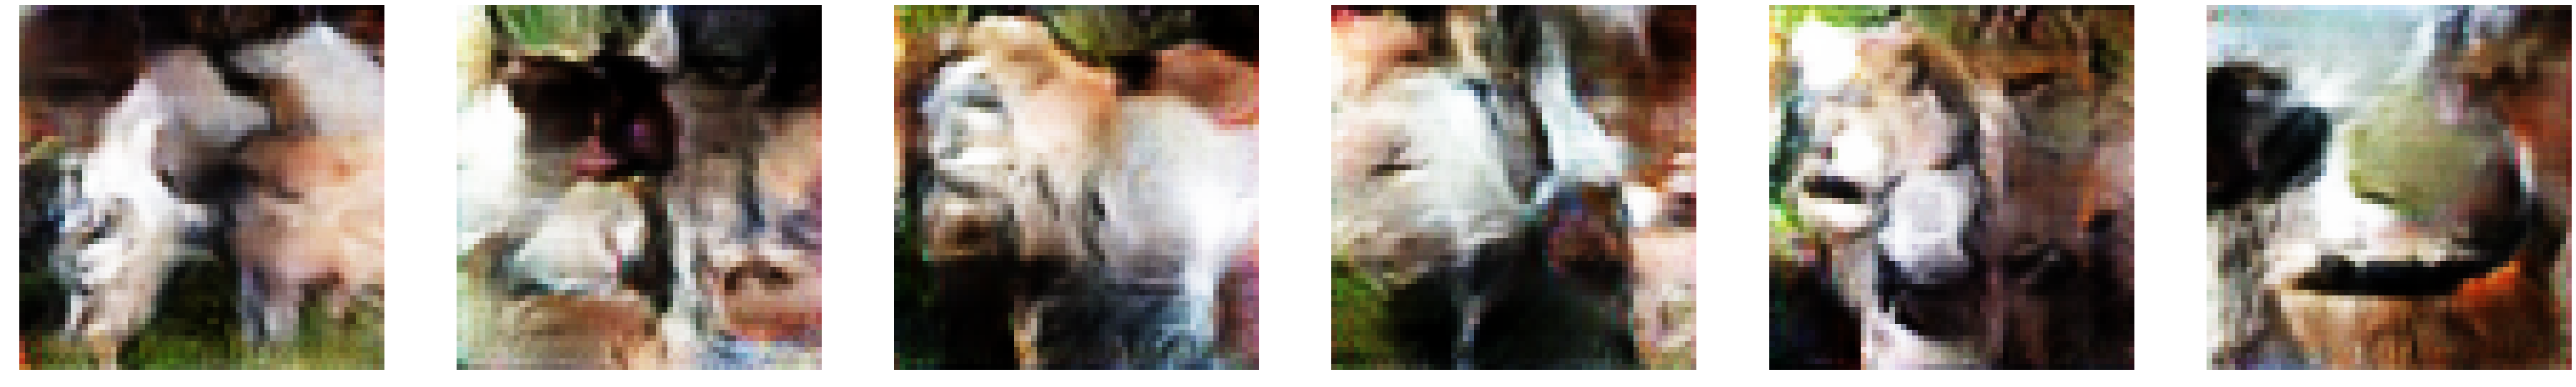

loss=rals 1epochの中での平均値 
 58.09s [102/301] Loss_D: 0.0596 Loss_G: 3.0272 outputR: -0.0088 outputF: -0.8388 / -0.8721
  最後のバッチのloss等 
    58.09s [102/301] Loss_D: 0.0779 Loss_G: 2.7583 outputR: -0.0998 outputF: -0.8209 / -0.9189
loss=rals 1epochの中での平均値 
 58.17s [103/301] Loss_D: 0.0588 Loss_G: 3.0139 outputR: 0.0122 outputF: -0.8173 / -0.8476
  最後のバッチのloss等 
    58.17s [103/301] Loss_D: 0.0657 Loss_G: 2.8601 outputR: 0.0864 outputF: -0.8286 / -0.7593
loss=rals 1epochの中での平均値 
 58.26s [104/301] Loss_D: 0.0626 Loss_G: 3.0063 outputR: 0.0221 outputF: -0.8028 / -0.8360
  最後のバッチのloss等 
    58.26s [104/301] Loss_D: 0.1904 Loss_G: 2.1540 outputR: -0.3268 outputF: -0.8009 / -0.8892
loss=rals 1epochの中での平均値 
 58.11s [105/301] Loss_D: 0.0619 Loss_G: 3.0186 outputR: 0.0751 outputF: -0.7506 / -0.7863
  最後のバッチのloss等 
    58.12s [105/301] Loss_D: 0.0576 Loss_G: 2.8755 outputR: 0.0329 outputF: -0.9322 / -0.8000
loss=rals 1epochの中での平均値 
 58.16s [106/301] Loss_D: 0.0550 Loss_G: 2.9856 outputR: -0.0160 out

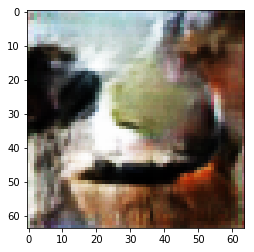

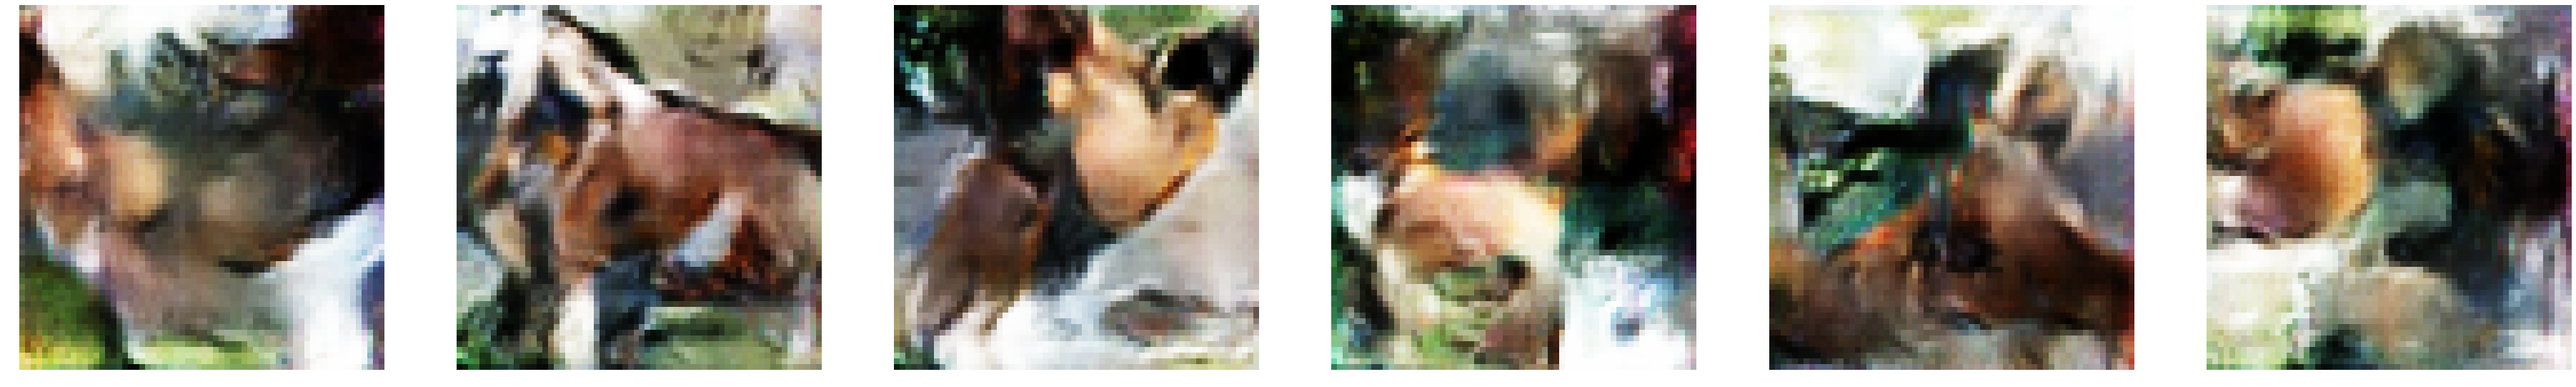

loss=rals 1epochの中での平均値 
 58.28s [112/301] Loss_D: 0.0553 Loss_G: 3.0070 outputR: 0.1137 outputF: -0.7202 / -0.7437
  最後のバッチのloss等 
    58.28s [112/301] Loss_D: 0.0262 Loss_G: 2.8191 outputR: -0.1063 outputF: -0.8673 / -0.8892
loss=rals 1epochの中での平均値 
 58.17s [113/301] Loss_D: 0.0603 Loss_G: 2.9823 outputR: 0.1105 outputF: -0.7169 / -0.7425
  最後のバッチのloss等 
    58.17s [113/301] Loss_D: 0.0499 Loss_G: 2.8107 outputR: -0.0744 outputF: -0.8470 / -0.8814
loss=rals 1epochの中での平均値 
 58.13s [114/301] Loss_D: 0.0574 Loss_G: 3.0137 outputR: 0.0728 outputF: -0.7605 / -0.7852
  最後のバッチのloss等 
    58.14s [114/301] Loss_D: 0.0612 Loss_G: 2.7087 outputR: 0.1534 outputF: -0.6295 / -0.6548
loss=rals 1epochの中での平均値 
 58.14s [115/301] Loss_D: 0.0562 Loss_G: 3.0000 outputR: 0.0106 outputF: -0.8223 / -0.8459
  最後のバッチのloss等 
    58.14s [115/301] Loss_D: 0.0652 Loss_G: 2.5983 outputR: 0.1685 outputF: -0.5629 / -0.6026
loss=rals 1epochの中での平均値 
 58.18s [116/301] Loss_D: 0.0596 Loss_G: 3.0225 outputR: 0.1015 outpu

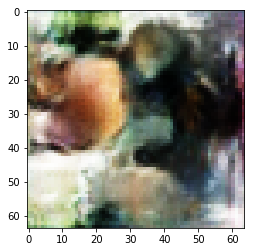

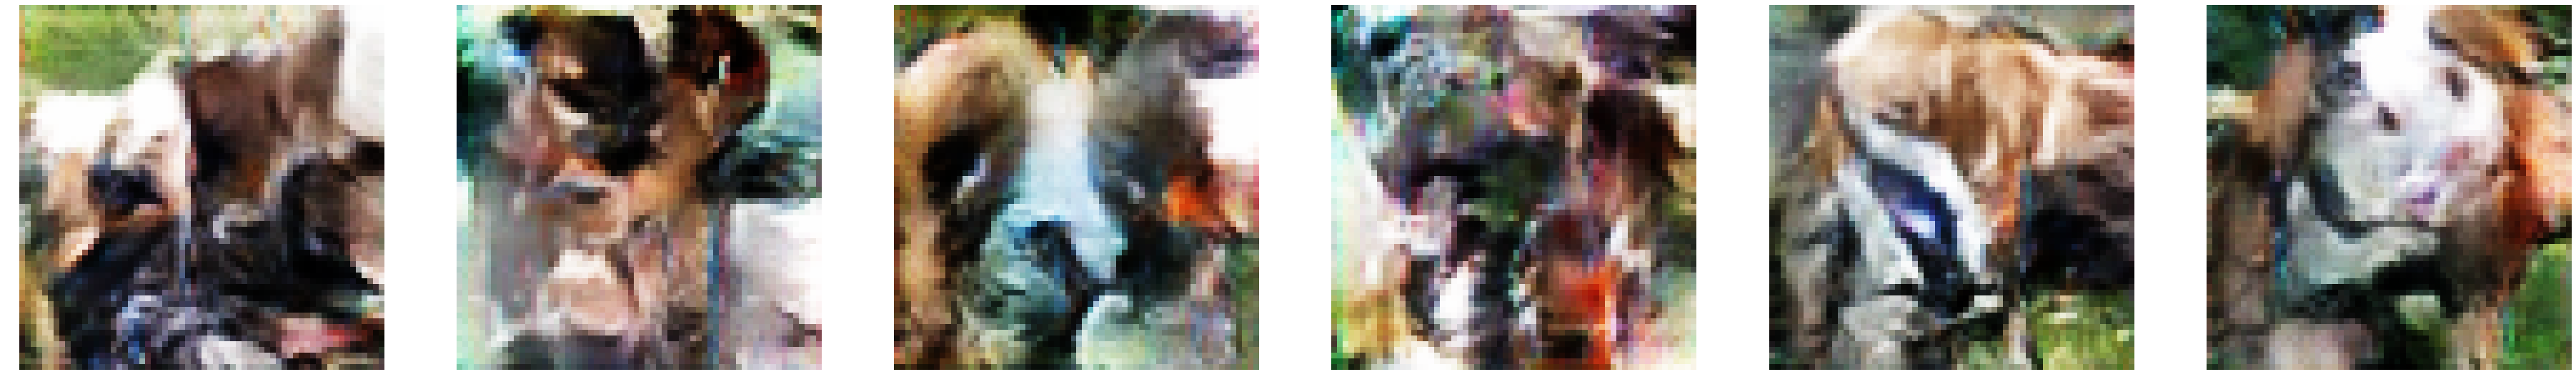

loss=rals 1epochの中での平均値 
 58.84s [122/301] Loss_D: 0.0525 Loss_G: 2.9767 outputR: 0.1337 outputF: -0.7019 / -0.7172
  最後のバッチのloss等 
    58.84s [122/301] Loss_D: 0.0731 Loss_G: 2.5475 outputR: -0.2343 outputF: -0.9769 / -0.9795
loss=rals 1epochの中での平均値 
 58.29s [123/301] Loss_D: 0.0534 Loss_G: 2.9909 outputR: 0.1663 outputF: -0.6690 / -0.6867
  最後のバッチのloss等 
    58.29s [123/301] Loss_D: 0.0452 Loss_G: 3.0262 outputR: 0.2502 outputF: -0.6330 / -0.6214
loss=rals 1epochの中での平均値 
 58.22s [124/301] Loss_D: 0.0493 Loss_G: 2.9951 outputR: 0.1891 outputF: -0.6518 / -0.6664
  最後のバッチのloss等 
    58.22s [124/301] Loss_D: 0.1098 Loss_G: 2.0978 outputR: -0.2086 outputF: -0.8198 / -0.8131
loss=rals 1epochの中での平均値 
 58.18s [125/301] Loss_D: 0.0551 Loss_G: 2.9772 outputR: 0.0928 outputF: -0.7396 / -0.7581
  最後のバッチのloss等 
    58.18s [125/301] Loss_D: 0.0535 Loss_G: 2.8254 outputR: 0.1454 outputF: -0.6082 / -0.6710
loss=rals 1epochの中での平均値 
 58.50s [126/301] Loss_D: 0.0558 Loss_G: 2.9896 outputR: 0.1716 outpu

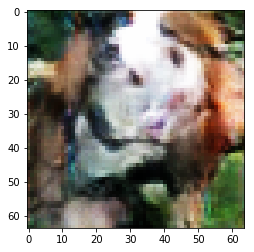

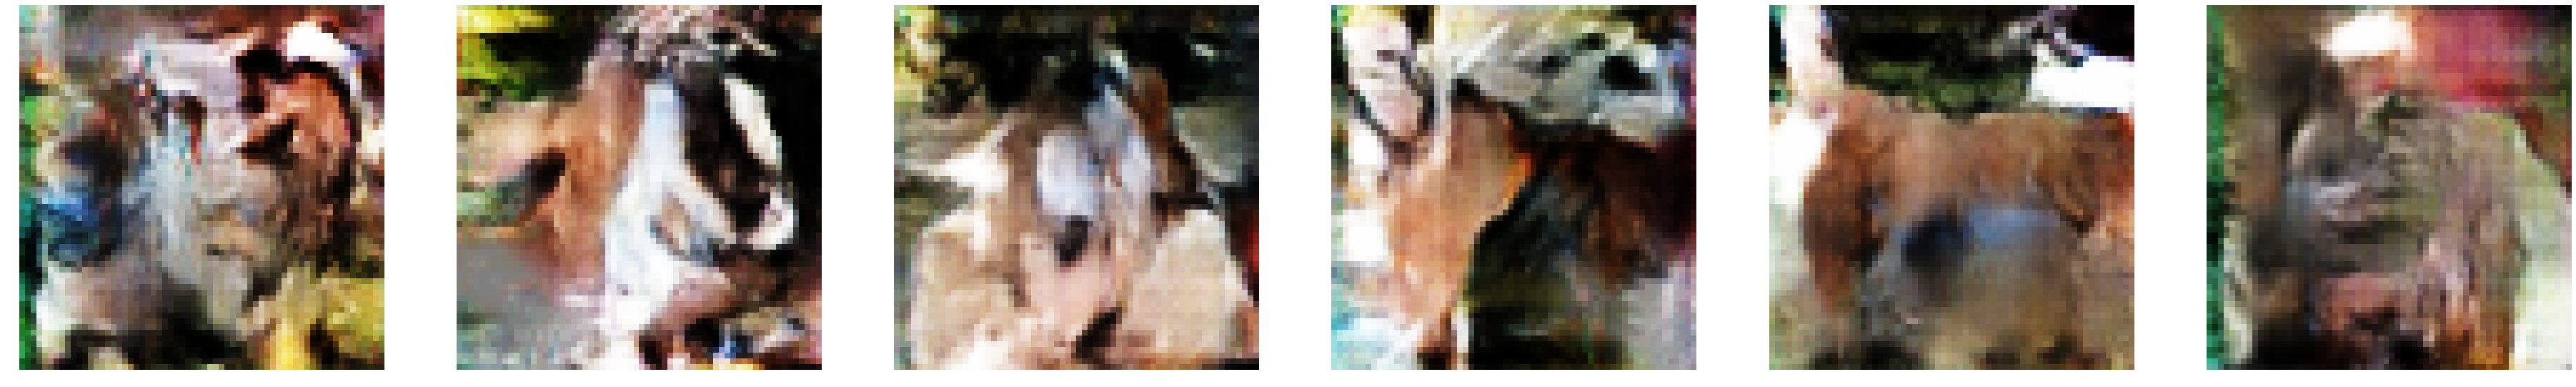

loss=rals 1epochの中での平均値 
 58.39s [132/301] Loss_D: 0.0479 Loss_G: 3.0089 outputR: 0.2964 outputF: -0.5471 / -0.5629
  最後のバッチのloss等 
    58.39s [132/301] Loss_D: 0.0053 Loss_G: 3.3554 outputR: 0.4087 outputF: -0.5373 / -0.5227
loss=rals 1epochの中での平均値 
 58.03s [133/301] Loss_D: 0.0517 Loss_G: 2.9927 outputR: 0.2668 outputF: -0.5726 / -0.5889
  最後のバッチのloss等 
    58.03s [133/301] Loss_D: 0.0234 Loss_G: 3.0994 outputR: 0.2629 outputF: -0.6022 / -0.6124
loss=rals 1epochの中での平均値 
 58.08s [134/301] Loss_D: 0.0490 Loss_G: 3.0163 outputR: 0.3570 outputF: -0.4850 / -0.5045
  最後のバッチのloss等 
    58.08s [134/301] Loss_D: 0.0037 Loss_G: 3.2031 outputR: 0.2426 outputF: -0.6444 / -0.6367
loss=rals 1epochの中での平均値 
 58.01s [135/301] Loss_D: 0.0490 Loss_G: 3.0039 outputR: 0.3250 outputF: -0.5155 / -0.5352
  最後のバッチのloss等 
    58.01s [135/301] Loss_D: 0.0538 Loss_G: 2.5969 outputR: 0.2133 outputF: -0.5184 / -0.5319
loss=rals 1epochの中での平均値 
 58.04s [136/301] Loss_D: 0.0473 Loss_G: 2.9889 outputR: 0.3633 outputF

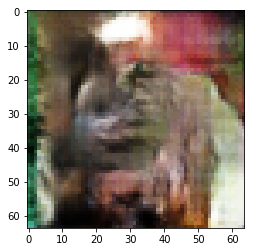

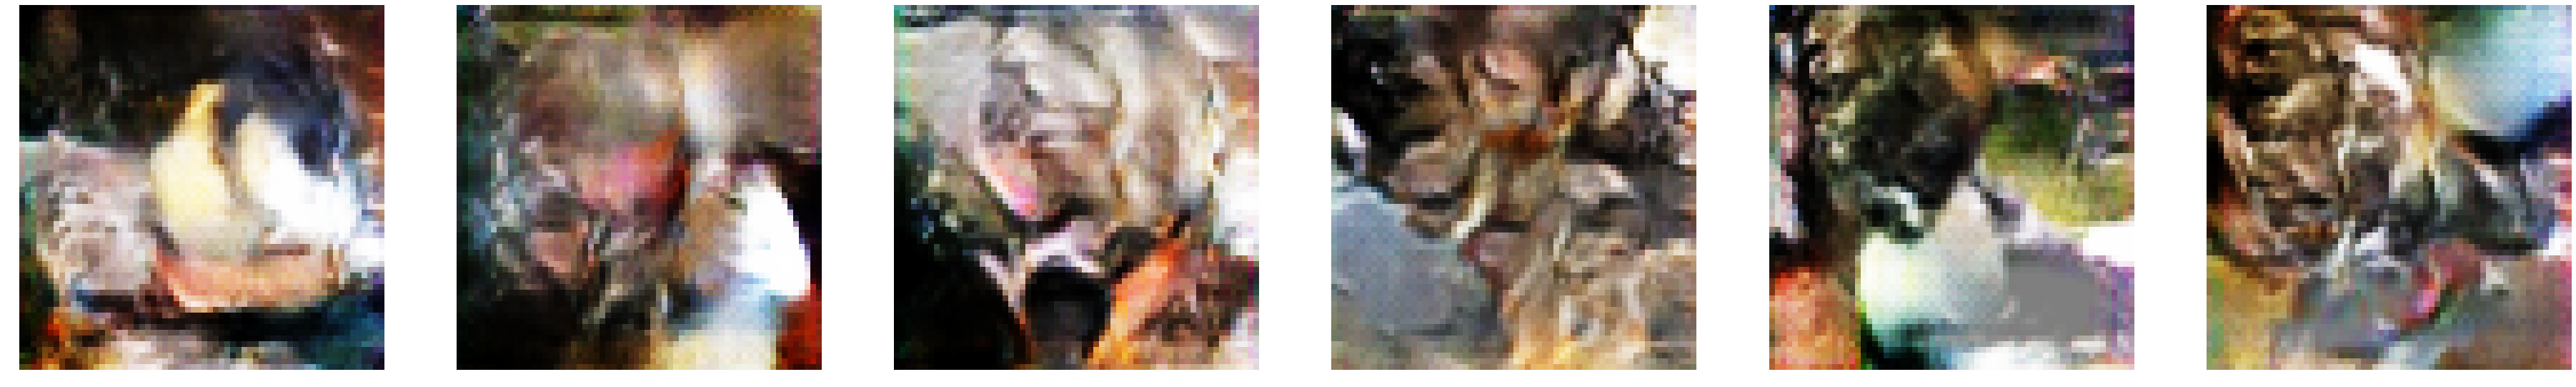

loss=rals 1epochの中での平均値 
 58.09s [142/301] Loss_D: 0.0441 Loss_G: 3.0115 outputR: 0.3936 outputF: -0.4532 / -0.4676
  最後のバッチのloss等 
    58.09s [142/301] Loss_D: 0.0605 Loss_G: 2.6173 outputR: 0.3208 outputF: -0.4543 / -0.4534
loss=rals 1epochの中での平均値 
 58.17s [143/301] Loss_D: 0.0450 Loss_G: 3.0100 outputR: 0.3650 outputF: -0.4801 / -0.4950
  最後のバッチのloss等 
    58.17s [143/301] Loss_D: 0.0335 Loss_G: 2.7914 outputR: 0.3726 outputF: -0.4086 / -0.4214
loss=rals 1epochの中での平均値 
 57.79s [144/301] Loss_D: 0.0419 Loss_G: 3.0202 outputR: 0.4341 outputF: -0.4165 / -0.4295
  最後のバッチのloss等 
    57.79s [144/301] Loss_D: 0.1037 Loss_G: 3.0436 outputR: 0.4677 outputF: -0.5758 / -0.4412
loss=rals 1epochの中での平均値 
 57.88s [145/301] Loss_D: 0.0430 Loss_G: 3.0134 outputR: 0.4305 outputF: -0.4173 / -0.4317
  最後のバッチのloss等 
    57.88s [145/301] Loss_D: 0.0251 Loss_G: 3.1594 outputR: 0.3551 outputF: -0.5558 / -0.5460
loss=rals 1epochの中での平均値 
 57.75s [146/301] Loss_D: 0.0442 Loss_G: 3.0170 outputR: 0.4663 outputF

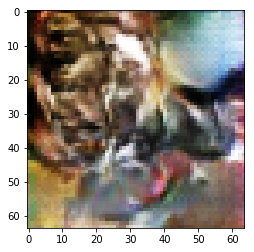

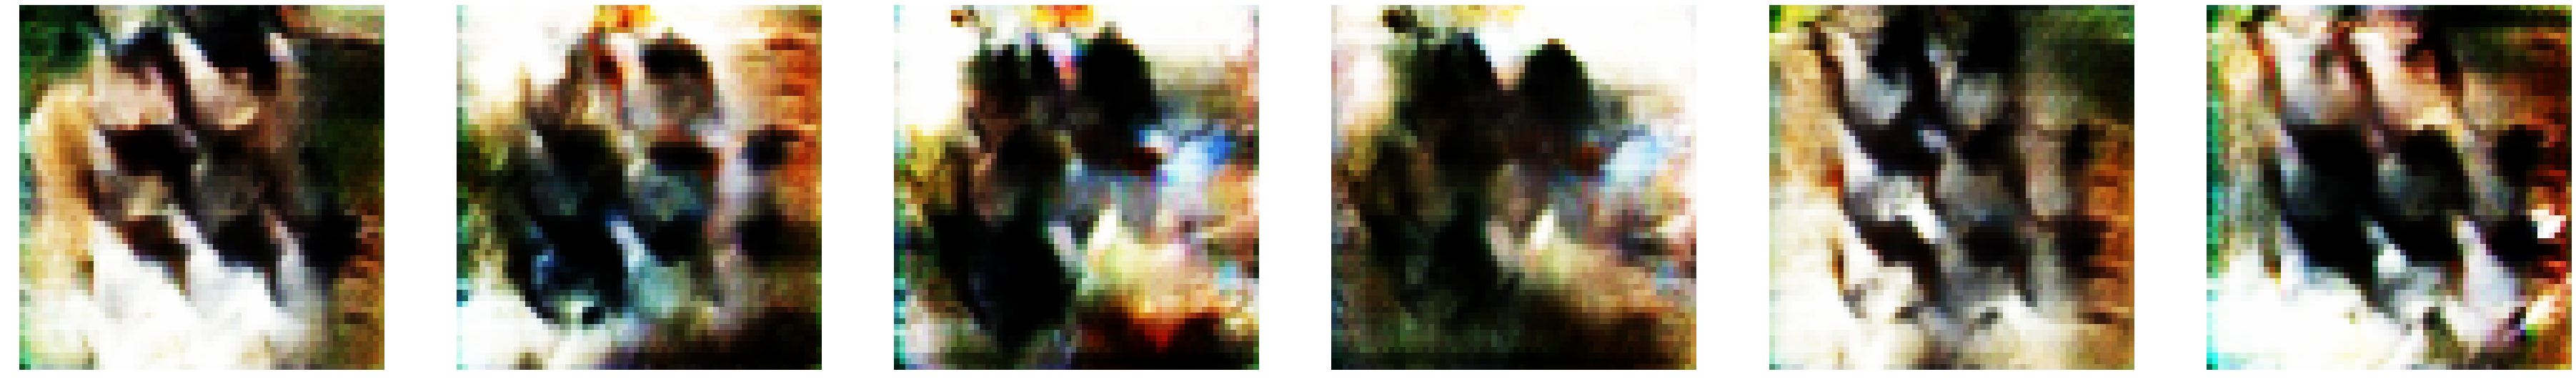

loss=rals 1epochの中での平均値 
 57.80s [152/301] Loss_D: 0.0391 Loss_G: 3.0129 outputR: 0.5073 outputF: -0.3450 / -0.3560
  最後のバッチのloss等 
    57.80s [152/301] Loss_D: 0.0627 Loss_G: 2.6502 outputR: 0.5208 outputF: -0.2466 / -0.2667
loss=rals 1epochの中での平均値 
 58.09s [153/301] Loss_D: 0.0379 Loss_G: 3.0203 outputR: 0.4881 outputF: -0.3648 / -0.3759
  最後のバッチのloss等 
    58.09s [153/301] Loss_D: 0.0063 Loss_G: 3.4350 outputR: 0.6198 outputF: -0.3434 / -0.3322
loss=rals 1epochの中での平均値 
 57.64s [154/301] Loss_D: 0.0376 Loss_G: 3.0001 outputR: 0.5047 outputF: -0.3488 / -0.3561
  最後のバッチのloss等 
    57.64s [154/301] Loss_D: 0.0289 Loss_G: 2.8342 outputR: 0.4795 outputF: -0.3183 / -0.3251
loss=rals 1epochの中での平均値 
 57.77s [155/301] Loss_D: 0.0388 Loss_G: 3.0171 outputR: 0.5025 outputF: -0.3500 / -0.3615
  最後のバッチのloss等 
    57.77s [155/301] Loss_D: 0.0672 Loss_G: 3.0515 outputR: 0.6171 outputF: -0.3039 / -0.2876
loss=rals 1epochの中での平均値 
 57.68s [156/301] Loss_D: 0.0395 Loss_G: 3.0274 outputR: 0.4986 outputF

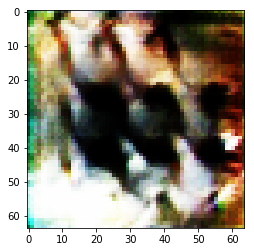

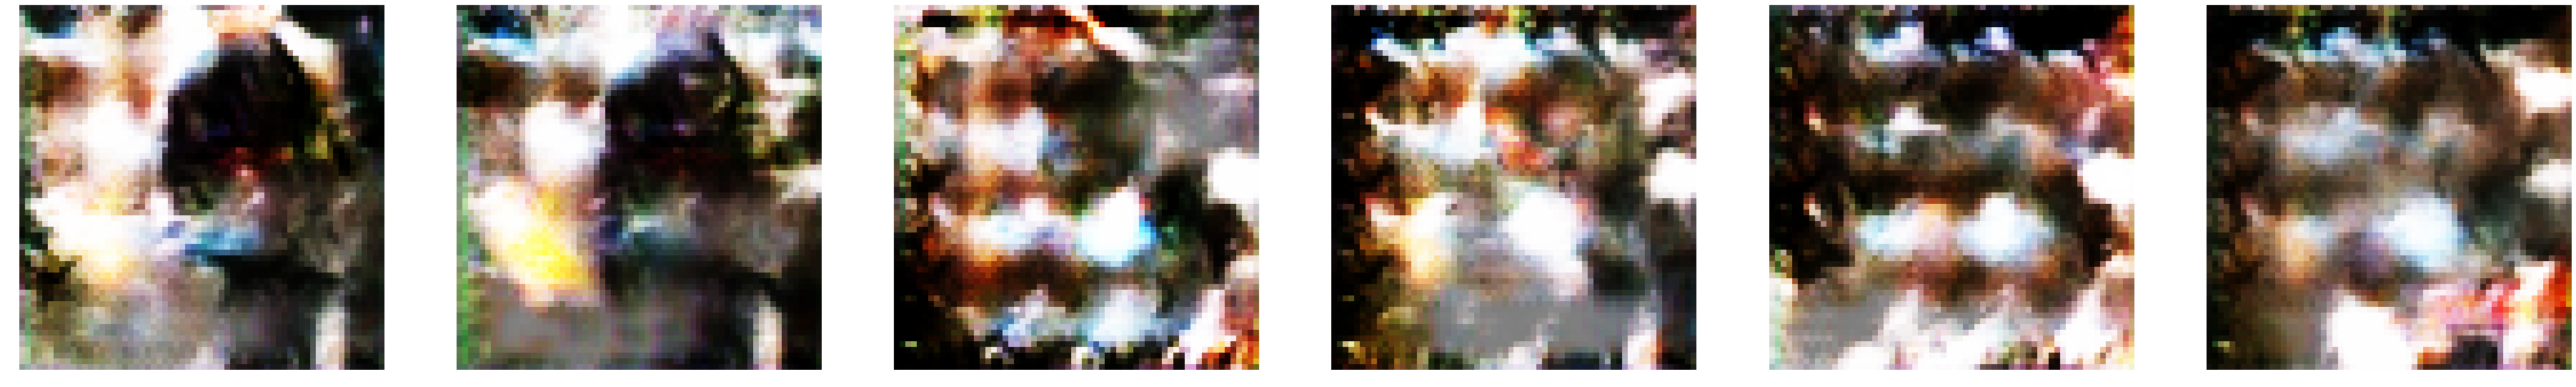

loss=rals 1epochの中での平均値 
 57.59s [162/301] Loss_D: 0.0396 Loss_G: 3.0360 outputR: 0.5621 outputF: -0.2888 / -0.3070
  最後のバッチのloss等 
    57.59s [162/301] Loss_D: 0.0407 Loss_G: 3.2110 outputR: 0.5834 outputF: -0.3473 / -0.3410
loss=rals 1epochの中での平均値 
 57.61s [163/301] Loss_D: 0.0415 Loss_G: 3.0433 outputR: 0.5424 outputF: -0.3066 / -0.3279
  最後のバッチのloss等 
    57.61s [163/301] Loss_D: 0.0368 Loss_G: 2.9946 outputR: 0.5664 outputF: -0.2938 / -0.2946
loss=rals 1epochの中での平均値 
 57.93s [164/301] Loss_D: 0.0448 Loss_G: 3.0482 outputR: 0.5400 outputF: -0.3036 / -0.3316
  最後のバッチのloss等 
    57.93s [164/301] Loss_D: 0.0441 Loss_G: 2.5655 outputR: 0.3096 outputF: -0.4140 / -0.4131
loss=rals 1epochの中での平均値 
 57.68s [165/301] Loss_D: 0.0391 Loss_G: 3.0241 outputR: 0.5889 outputF: -0.2636 / -0.2769
  最後のバッチのloss等 
    57.68s [165/301] Loss_D: 0.0047 Loss_G: 3.4321 outputR: 0.6707 outputF: -0.2623 / -0.2822
loss=rals 1epochの中での平均値 
 57.72s [166/301] Loss_D: 0.0397 Loss_G: 3.0166 outputR: 0.6072 outputF

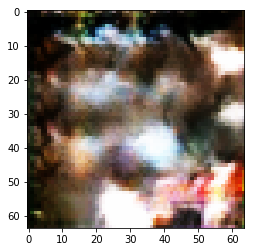

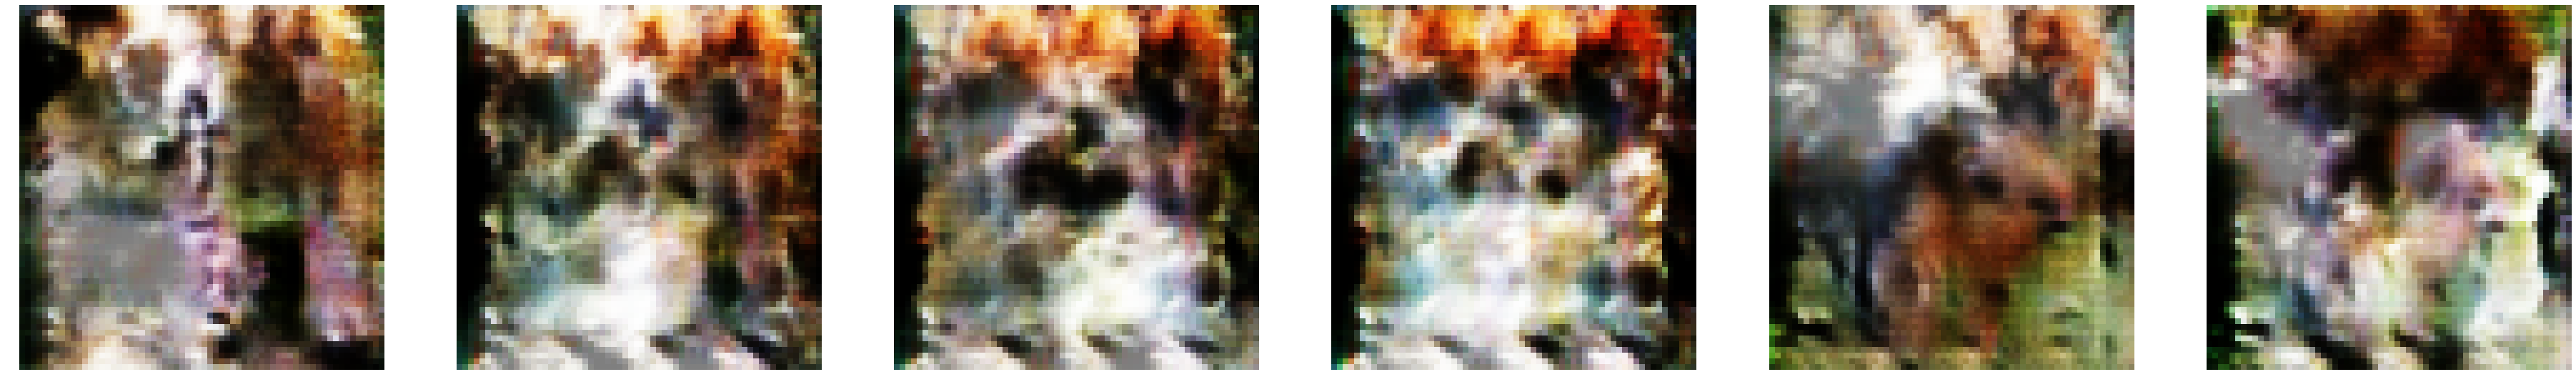

loss=rals 1epochの中での平均値 
 57.71s [172/301] Loss_D: 0.0383 Loss_G: 3.0182 outputR: 0.5930 outputF: -0.2597 / -0.2716
  最後のバッチのloss等 
    57.71s [172/301] Loss_D: 0.0296 Loss_G: 2.7545 outputR: 0.5179 outputF: -0.2618 / -0.2626
loss=rals 1epochの中での平均値 
 57.63s [173/301] Loss_D: 0.0416 Loss_G: 3.0242 outputR: 0.6192 outputF: -0.2296 / -0.2479
  最後のバッチのloss等 
    57.63s [173/301] Loss_D: 0.0714 Loss_G: 3.0297 outputR: 0.4873 outputF: -0.4382 / -0.4099
loss=rals 1epochの中での平均値 
 57.82s [174/301] Loss_D: 0.0392 Loss_G: 3.0456 outputR: 0.5842 outputF: -0.2667 / -0.2863
  最後のバッチのloss等 
    57.82s [174/301] Loss_D: 0.0469 Loss_G: 2.5143 outputR: 0.4074 outputF: -0.2816 / -0.2768
loss=rals 1epochの中での平均値 
 57.70s [175/301] Loss_D: 0.0400 Loss_G: 3.0162 outputR: 0.6337 outputF: -0.2163 / -0.2320
  最後のバッチのloss等 
    57.70s [175/301] Loss_D: 0.0272 Loss_G: 2.8671 outputR: 0.5478 outputF: -0.2701 / -0.2685
loss=rals 1epochの中での平均値 
 57.68s [176/301] Loss_D: 0.0386 Loss_G: 3.0359 outputR: 0.6302 outputF

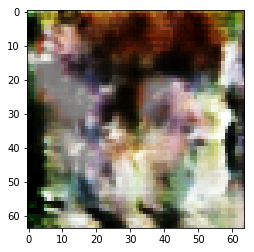

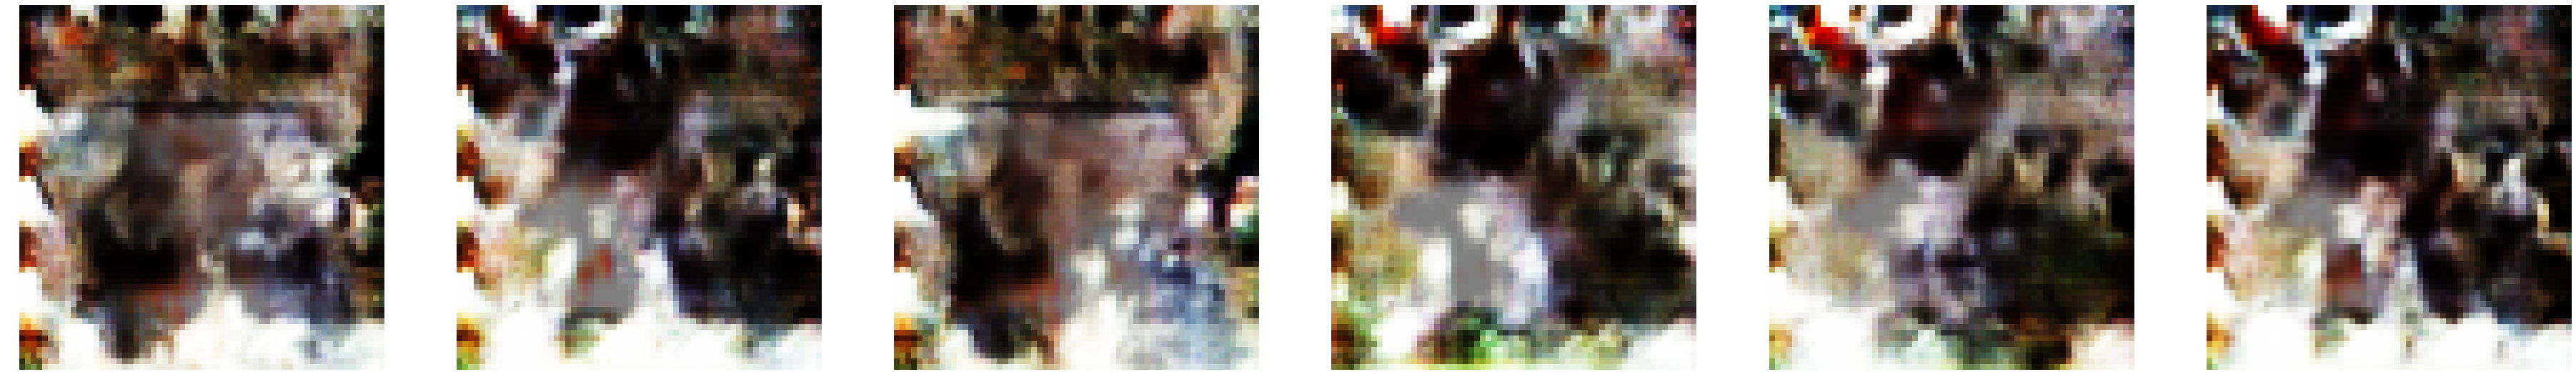

loss=rals 1epochの中での平均値 
 57.78s [182/301] Loss_D: 0.0360 Loss_G: 3.0107 outputR: 0.6701 outputF: -0.1850 / -0.1937
  最後のバッチのloss等 
    57.78s [182/301] Loss_D: 0.0390 Loss_G: 2.9718 outputR: 0.6811 outputF: -0.1879 / -0.1867
loss=rals 1epochの中での平均値 
 57.60s [183/301] Loss_D: 0.0328 Loss_G: 3.0239 outputR: 0.6428 outputF: -0.2157 / -0.2232
  最後のバッチのloss等 
    57.60s [183/301] Loss_D: 0.0555 Loss_G: 2.9945 outputR: 0.6741 outputF: -0.2159 / -0.2103
loss=rals 1epochの中での平均値 
 57.68s [184/301] Loss_D: 0.0332 Loss_G: 3.0215 outputR: 0.6716 outputF: -0.1868 / -0.1939
  最後のバッチのloss等 
    57.68s [184/301] Loss_D: 0.0395 Loss_G: 2.9032 outputR: 0.6505 outputF: -0.1955 / -0.1950
loss=rals 1epochの中での平均値 
 57.98s [185/301] Loss_D: 0.0352 Loss_G: 3.0292 outputR: 0.6616 outputF: -0.1946 / -0.2063
  最後のバッチのloss等 
    57.98s [185/301] Loss_D: 0.0628 Loss_G: 3.0505 outputR: 0.7160 outputF: -0.2105 / -0.1877
loss=rals 1epochの中での平均値 
 57.68s [186/301] Loss_D: 0.0376 Loss_G: 3.0213 outputR: 0.6691 outputF

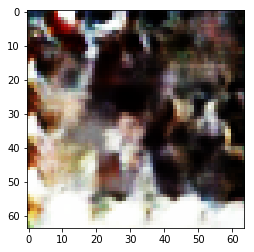

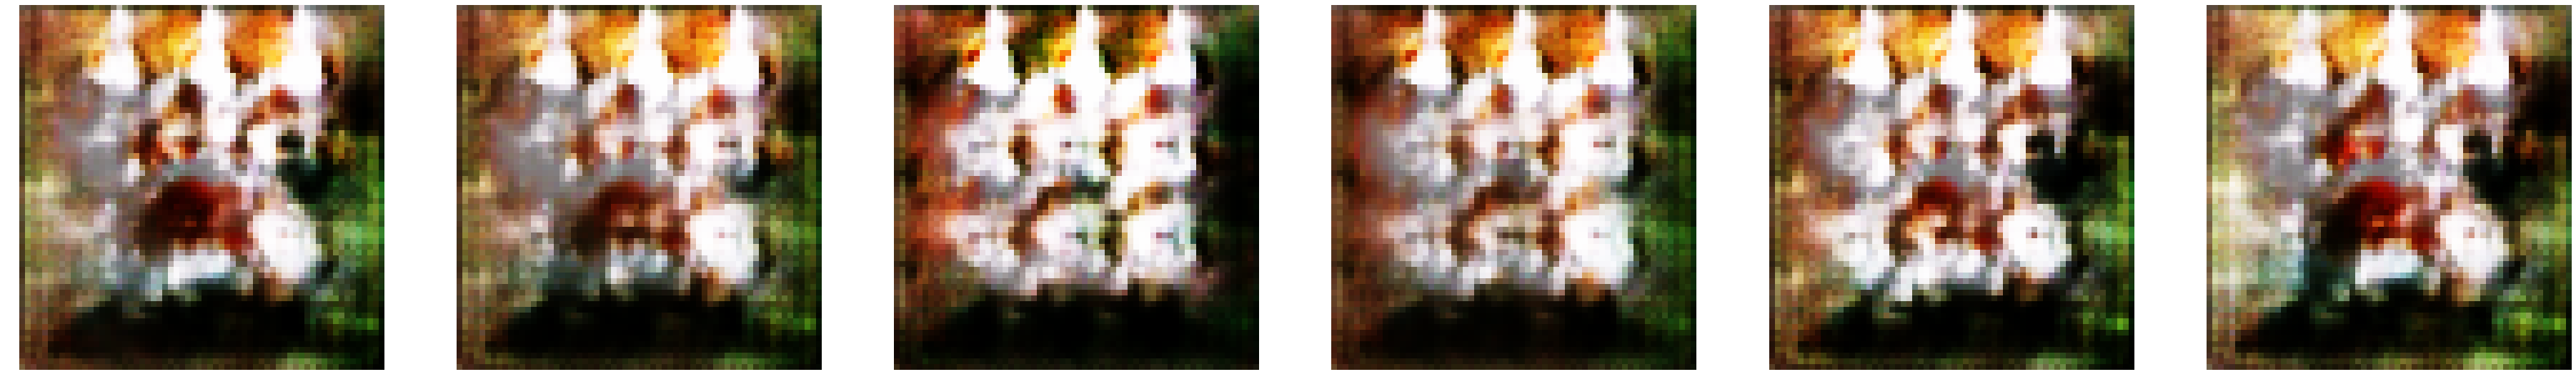

loss=rals 1epochの中での平均値 
 57.95s [192/301] Loss_D: 0.0356 Loss_G: 3.0361 outputR: 0.6770 outputF: -0.1795 / -0.1925
  最後のバッチのloss等 
    57.95s [192/301] Loss_D: 0.0222 Loss_G: 3.2122 outputR: 0.7598 outputF: -0.1641 / -0.1584
loss=rals 1epochの中での平均値 
 58.15s [193/301] Loss_D: 0.0417 Loss_G: 3.0573 outputR: 0.6751 outputF: -0.1697 / -0.1988
  最後のバッチのloss等 
    58.15s [193/301] Loss_D: 0.0429 Loss_G: 2.8908 outputR: 0.5329 outputF: -0.3214 / -0.2889
loss=rals 1epochの中での平均値 
 58.86s [194/301] Loss_D: 0.0536 Loss_G: 3.0604 outputR: 0.6886 outputF: -0.1403 / -0.1867
  最後のバッチのloss等 
    58.86s [194/301] Loss_D: 0.0672 Loss_G: 2.9383 outputR: 1.0425 outputF: 0.1324 / 0.1773
loss=rals 1epochの中での平均値 
 58.66s [195/301] Loss_D: 0.0512 Loss_G: 3.0701 outputR: 0.8393 outputF: 0.0065 / -0.0376
  最後のバッチのloss等 
    58.66s [195/301] Loss_D: 0.0620 Loss_G: 2.9011 outputR: 0.7425 outputF: -0.1172 / -0.1282
loss=rals 1epochの中での平均値 
 58.05s [196/301] Loss_D: 0.0526 Loss_G: 3.0077 outputR: 0.6144 outputF: -

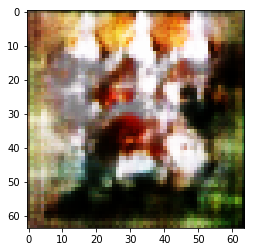

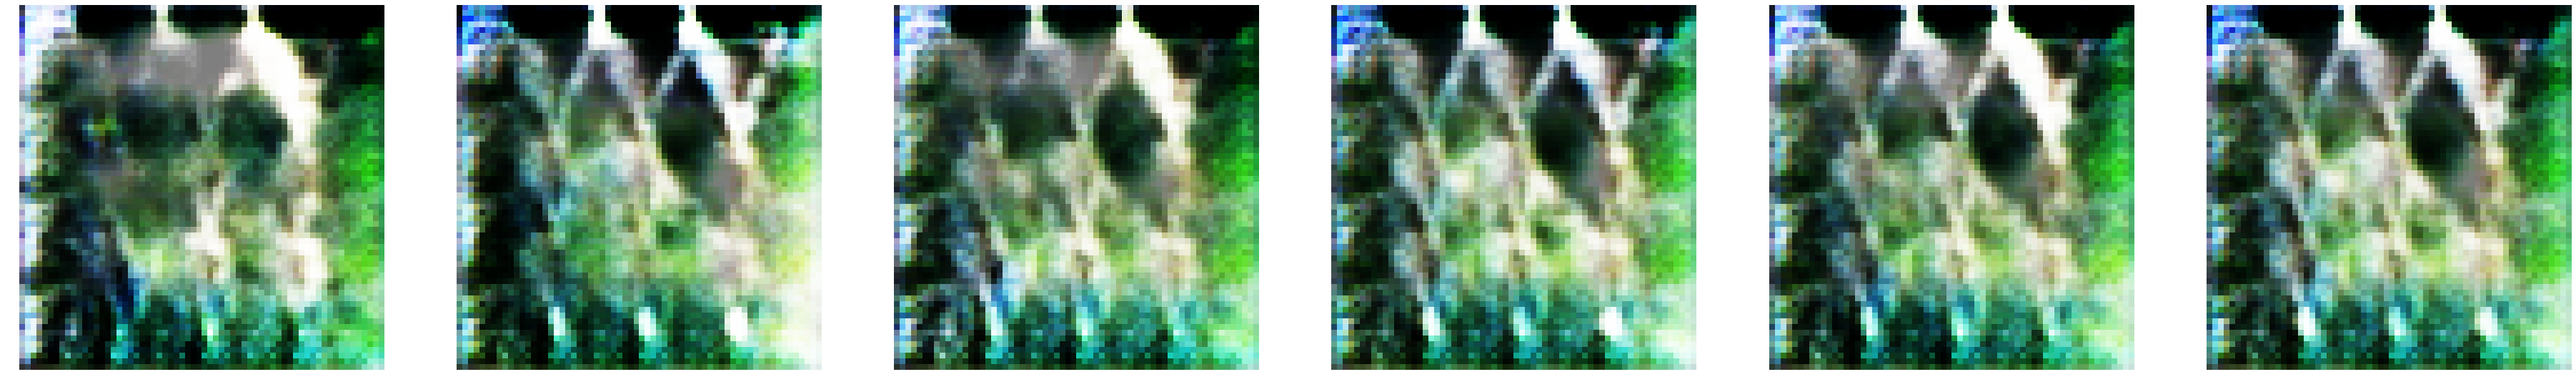

loss=rals 1epochの中での平均値 
 57.70s [202/301] Loss_D: 0.0467 Loss_G: 3.0315 outputR: 0.7014 outputF: -0.1408 / -0.1651
  最後のバッチのloss等 
    57.70s [202/301] Loss_D: 0.0419 Loss_G: 3.2334 outputR: 0.4571 outputF: -0.4533 / -0.4764
loss=rals 1epochの中での平均値 
 57.57s [203/301] Loss_D: 0.0496 Loss_G: 3.0250 outputR: 0.5065 outputF: -0.3315 / -0.3582
  最後のバッチのloss等 
    57.57s [203/301] Loss_D: 0.0373 Loss_G: 2.7753 outputR: 0.5737 outputF: -0.2765 / -0.2269
loss=rals 1epochの中での平均値 
 57.58s [204/301] Loss_D: 0.0490 Loss_G: 3.0044 outputR: 0.5571 outputF: -0.2823 / -0.3021
  最後のバッチのloss等 
    57.58s [204/301] Loss_D: 0.0511 Loss_G: 3.5039 outputR: 0.2128 outputF: -0.7371 / -0.7975
loss=rals 1epochの中での平均値 
 57.54s [205/301] Loss_D: 0.0520 Loss_G: 3.0083 outputR: 0.5737 outputF: -0.2627 / -0.2879
  最後のバッチのloss等 
    57.54s [205/301] Loss_D: 0.0666 Loss_G: 2.7665 outputR: 0.4337 outputF: -0.2505 / -0.3668
loss=rals 1epochの中での平均値 
 57.80s [206/301] Loss_D: 0.0481 Loss_G: 3.0166 outputR: 0.4926 outputF

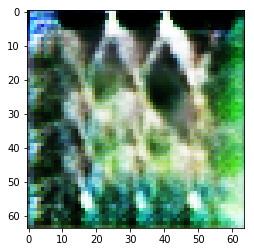

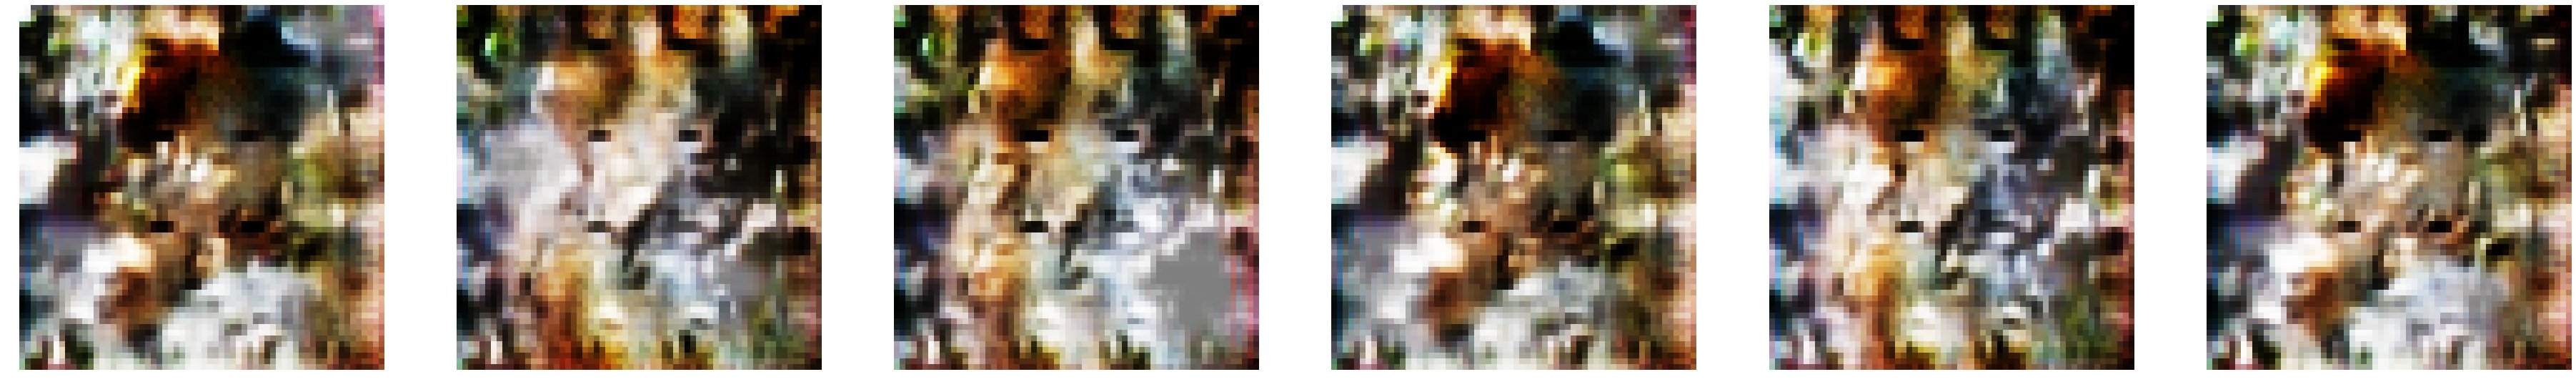

loss=rals 1epochの中での平均値 
 57.78s [212/301] Loss_D: 0.0491 Loss_G: 3.0034 outputR: 0.3984 outputF: -0.4392 / -0.4593
  最後のバッチのloss等 
    57.78s [212/301] Loss_D: 0.1033 Loss_G: 3.3616 outputR: 0.3145 outputF: -0.7104 / -0.6844
loss=rals 1epochの中での平均値 
 57.78s [213/301] Loss_D: 0.0483 Loss_G: 3.0044 outputR: 0.2897 outputF: -0.5506 / -0.5689
  最後のバッチのloss等 
    57.78s [213/301] Loss_D: 0.0163 Loss_G: 2.8207 outputR: 0.0988 outputF: -0.6914 / -0.6812
loss=rals 1epochの中での平均値 
 57.59s [214/301] Loss_D: 0.0496 Loss_G: 3.0088 outputR: 0.3033 outputF: -0.5349 / -0.5563
  最後のバッチのloss等 
    57.59s [214/301] Loss_D: 0.1020 Loss_G: 3.7140 outputR: 0.4472 outputF: -0.5948 / -0.6290
loss=rals 1epochの中での平均値 
 57.56s [215/301] Loss_D: 0.0490 Loss_G: 3.0080 outputR: 0.5117 outputF: -0.3295 / -0.3482
  最後のバッチのloss等 
    57.56s [215/301] Loss_D: 0.0459 Loss_G: 2.6606 outputR: 0.3569 outputF: -0.3334 / -0.3767
loss=rals 1epochの中での平均値 
 57.80s [216/301] Loss_D: 0.0515 Loss_G: 3.0047 outputR: 0.4316 outputF

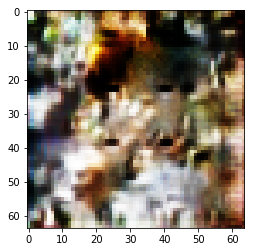

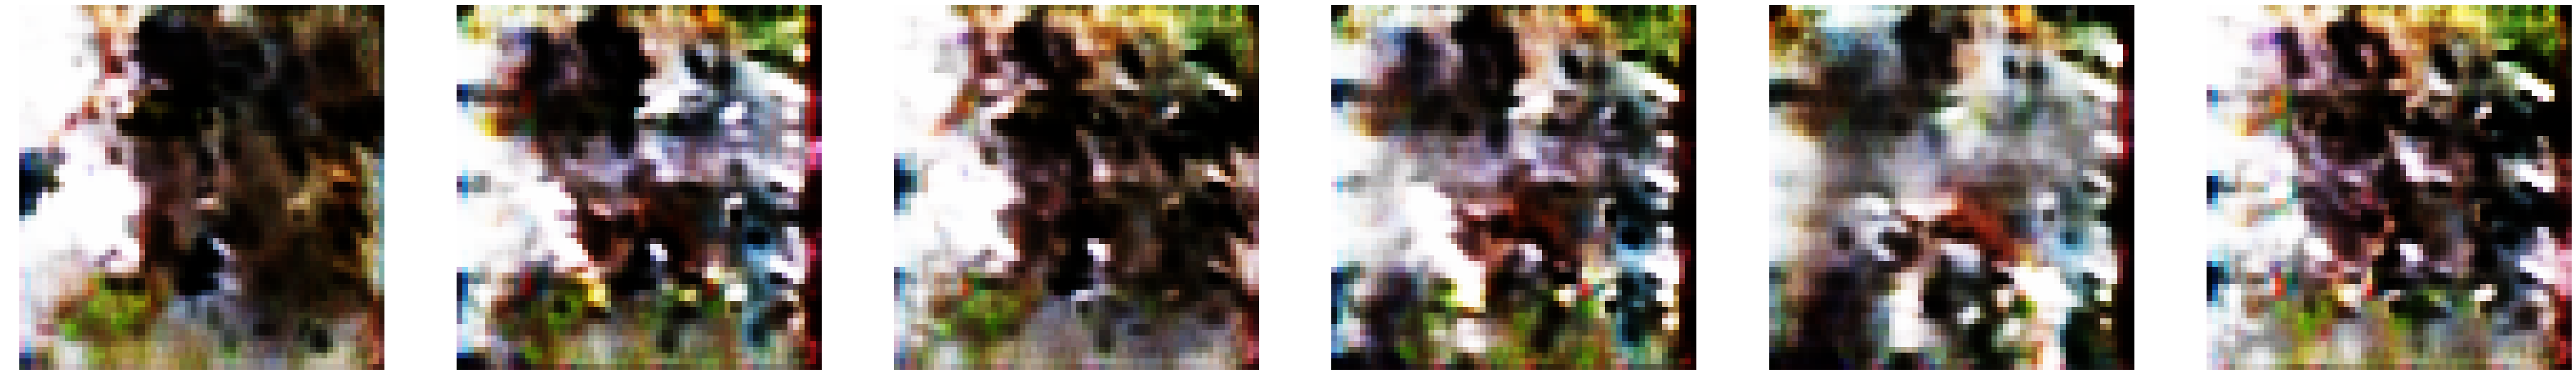

loss=rals 1epochの中での平均値 
 57.65s [222/301] Loss_D: 0.0509 Loss_G: 3.0267 outputR: 0.4264 outputF: -0.4119 / -0.4379
  最後のバッチのloss等 
    57.65s [222/301] Loss_D: 0.0206 Loss_G: 3.1056 outputR: 0.5540 outputF: -0.2748 / -0.3225
loss=rals 1epochの中での平均値 
 57.79s [223/301] Loss_D: 0.0514 Loss_G: 3.0296 outputR: 0.3831 outputF: -0.4551 / -0.4819
  最後のバッチのloss等 
    57.79s [223/301] Loss_D: 0.0281 Loss_G: 2.8903 outputR: 0.4448 outputF: -0.3152 / -0.3481
loss=rals 1epochの中での平均値 
 57.66s [224/301] Loss_D: 0.0516 Loss_G: 3.0248 outputR: 0.3766 outputF: -0.4619 / -0.4878
  最後のバッチのloss等 
    57.66s [224/301] Loss_D: 0.0081 Loss_G: 3.4425 outputR: 0.1720 outputF: -0.6885 / -0.7803
loss=rals 1epochの中での平均値 
 57.59s [225/301] Loss_D: 0.0536 Loss_G: 3.0072 outputR: 0.4069 outputF: -0.4290 / -0.4537
  最後のバッチのloss等 
    57.59s [225/301] Loss_D: 0.0948 Loss_G: 2.8323 outputR: 0.2768 outputF: -0.3496 / -0.5229
loss=rals 1epochの中での平均値 
 57.57s [226/301] Loss_D: 0.0465 Loss_G: 2.9999 outputR: 0.2562 outputF

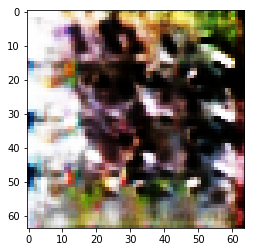

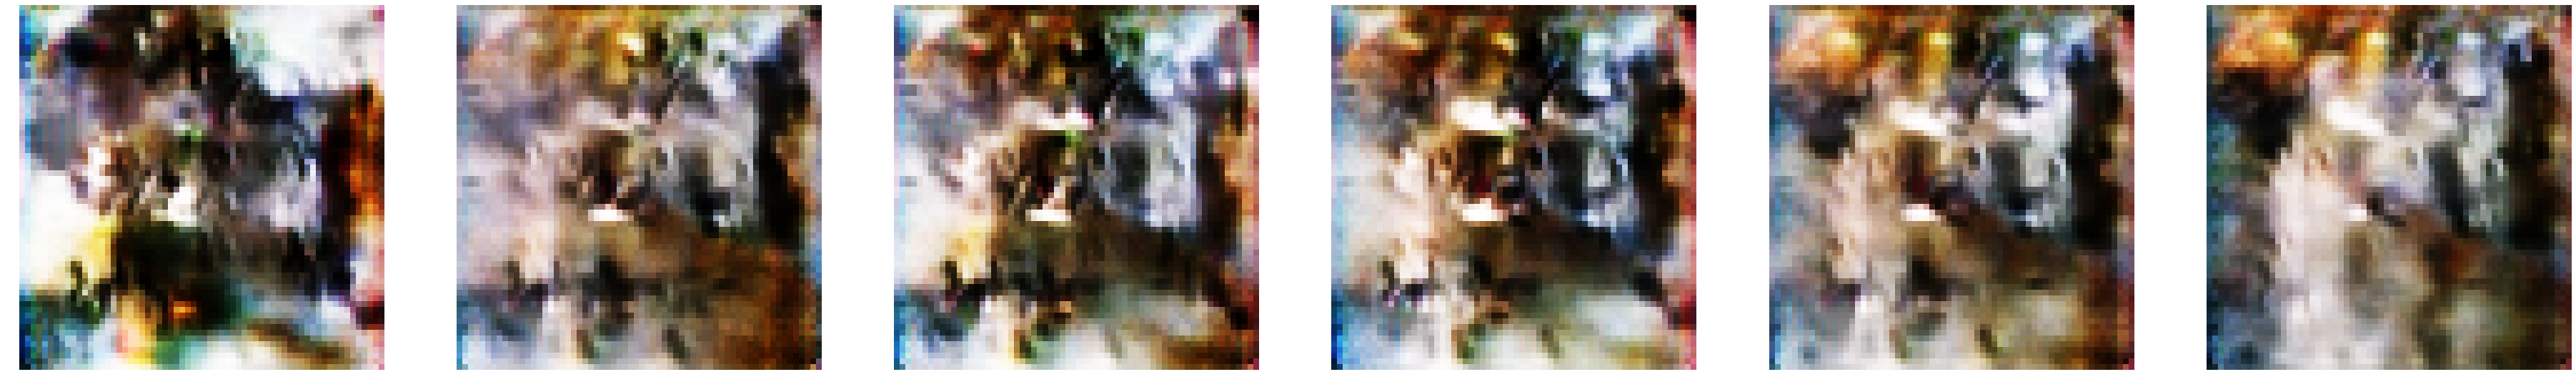

loss=rals 1epochの中での平均値 
 57.83s [232/301] Loss_D: 0.0480 Loss_G: 3.0107 outputR: 0.3175 outputF: -0.5231 / -0.5440
  最後のバッチのloss等 
    57.83s [232/301] Loss_D: 0.0710 Loss_G: 2.9970 outputR: 0.2654 outputF: -0.6876 / -0.6235
loss=rals 1epochの中での平均値 
 57.71s [233/301] Loss_D: 0.0477 Loss_G: 3.0313 outputR: 0.2190 outputF: -0.6214 / -0.6451
  最後のバッチのloss等 
    57.71s [233/301] Loss_D: 0.0865 Loss_G: 2.6793 outputR: -0.0353 outputF: -0.6776 / -0.8168
loss=rals 1epochの中での平均値 
 57.60s [234/301] Loss_D: 0.0520 Loss_G: 3.0078 outputR: 0.2462 outputF: -0.5906 / -0.6138
  最後のバッチのloss等 
    57.60s [234/301] Loss_D: 0.0598 Loss_G: 3.2566 outputR: 0.5538 outputF: -0.4268 / -0.3863
loss=rals 1epochの中での平均値 
 57.67s [235/301] Loss_D: 0.0501 Loss_G: 3.0276 outputR: 0.3347 outputF: -0.5044 / -0.5306
  最後のバッチのloss等 
    57.67s [235/301] Loss_D: 0.0173 Loss_G: 3.0588 outputR: 0.4567 outputF: -0.3277 / -0.3932
loss=rals 1epochの中での平均値 
 57.58s [236/301] Loss_D: 0.0520 Loss_G: 3.0202 outputR: 0.3842 output

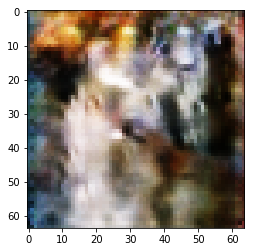

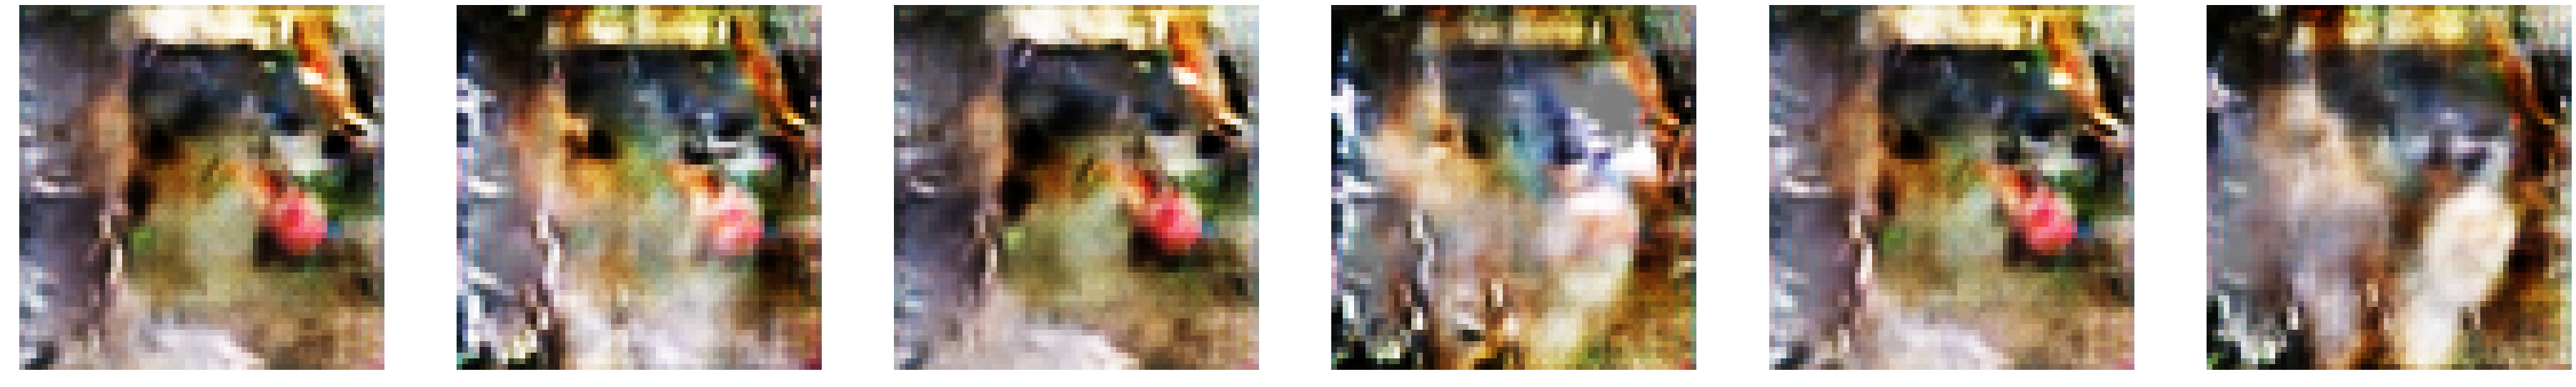

loss=rals 1epochの中での平均値 
 57.84s [242/301] Loss_D: 0.0498 Loss_G: 3.0017 outputR: 0.2883 outputF: -0.5464 / -0.5709
  最後のバッチのloss等 
    57.84s [242/301] Loss_D: 0.0370 Loss_G: 3.1629 outputR: 0.2654 outputF: -0.4935 / -0.6356
loss=rals 1epochの中での平均値 
 57.59s [243/301] Loss_D: 0.0492 Loss_G: 3.0036 outputR: 0.2919 outputF: -0.5473 / -0.5663
  最後のバッチのloss等 
    57.59s [243/301] Loss_D: 0.1021 Loss_G: 2.8998 outputR: 0.5796 outputF: -0.4494 / -0.2885
loss=rals 1epochの中での平均値 
 57.71s [244/301] Loss_D: 0.0489 Loss_G: 3.0125 outputR: 0.3424 outputF: -0.4968 / -0.5181
  最後のバッチのloss等 
    57.71s [244/301] Loss_D: 0.0238 Loss_G: 2.9917 outputR: 0.5234 outputF: -0.3316 / -0.3246
loss=rals 1epochの中での平均値 
 57.60s [245/301] Loss_D: 0.0483 Loss_G: 3.0229 outputR: 0.3519 outputF: -0.4892 / -0.5110
  最後のバッチのloss等 
    57.60s [245/301] Loss_D: 0.0281 Loss_G: 3.2693 outputR: 0.0731 outputF: -0.8381 / -0.8554
loss=rals 1epochの中での平均値 
 57.62s [246/301] Loss_D: 0.0498 Loss_G: 3.0102 outputR: 0.2735 outputF

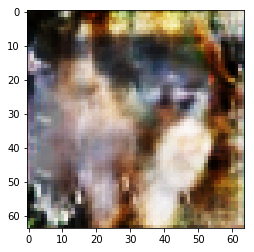

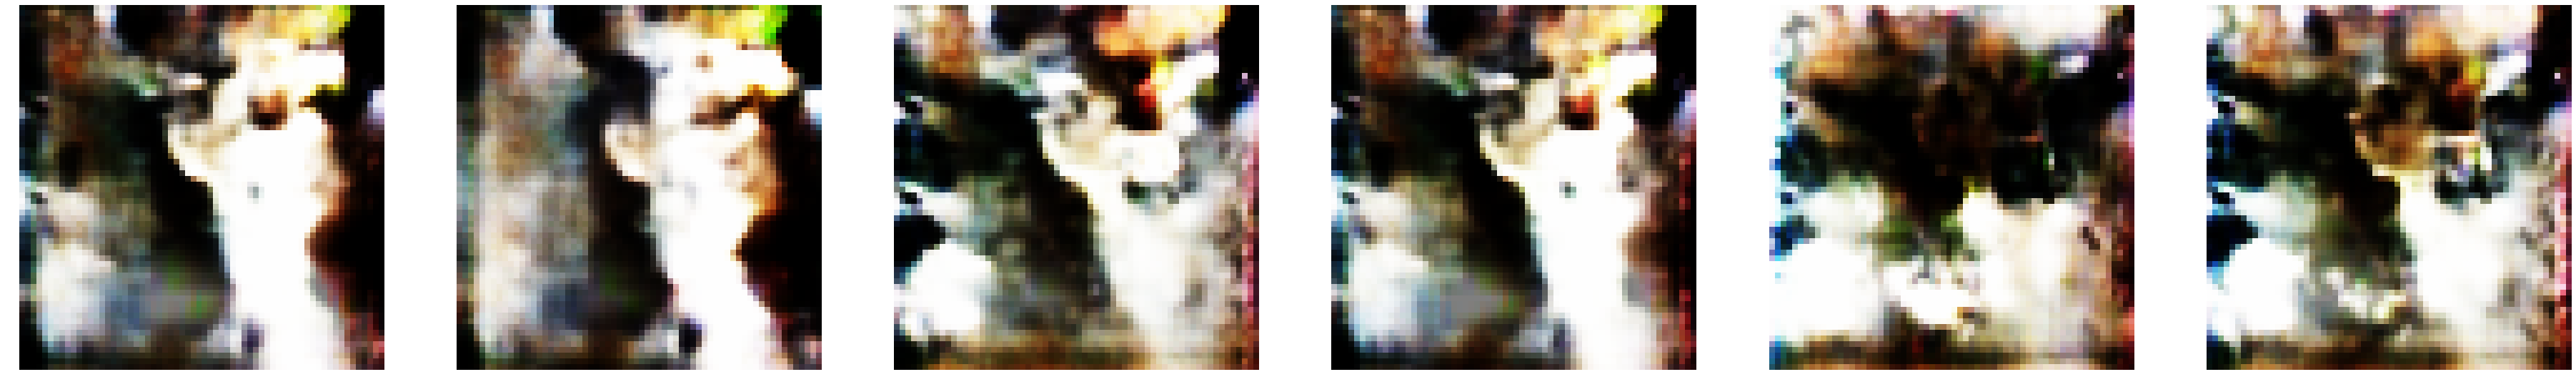

loss=rals 1epochの中での平均値 
 58.82s [252/301] Loss_D: 0.0523 Loss_G: 3.0230 outputR: 0.2365 outputF: -0.5986 / -0.6283
  最後のバッチのloss等 
    58.82s [252/301] Loss_D: 0.0110 Loss_G: 3.1854 outputR: 0.4211 outputF: -0.4347 / -0.4615
loss=rals 1epochの中での平均値 
 59.18s [253/301] Loss_D: 0.0482 Loss_G: 3.0443 outputR: 0.3425 outputF: -0.4993 / -0.5262
  最後のバッチのloss等 
    59.18s [253/301] Loss_D: 0.0452 Loss_G: 3.0483 outputR: 0.4087 outputF: -0.5233 / -0.4776
loss=rals 1epochの中での平均値 
 58.82s [254/301] Loss_D: 0.0485 Loss_G: 3.0286 outputR: 0.3019 outputF: -0.5386 / -0.5626
  最後のバッチのloss等 
    58.82s [254/301] Loss_D: 0.0625 Loss_G: 2.8941 outputR: 0.4032 outputF: -0.5133 / -0.4541
loss=rals 1epochの中での平均値 
 58.98s [255/301] Loss_D: 0.0503 Loss_G: 3.0331 outputR: 0.2601 outputF: -0.5791 / -0.6060
  最後のバッチのloss等 
    58.98s [255/301] Loss_D: 0.0721 Loss_G: 2.3848 outputR: 0.2753 outputF: -0.4449 / -0.4212
loss=rals 1epochの中での平均値 
 58.87s [256/301] Loss_D: 0.0491 Loss_G: 2.9896 outputR: 0.2648 outputF

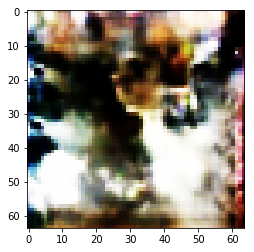

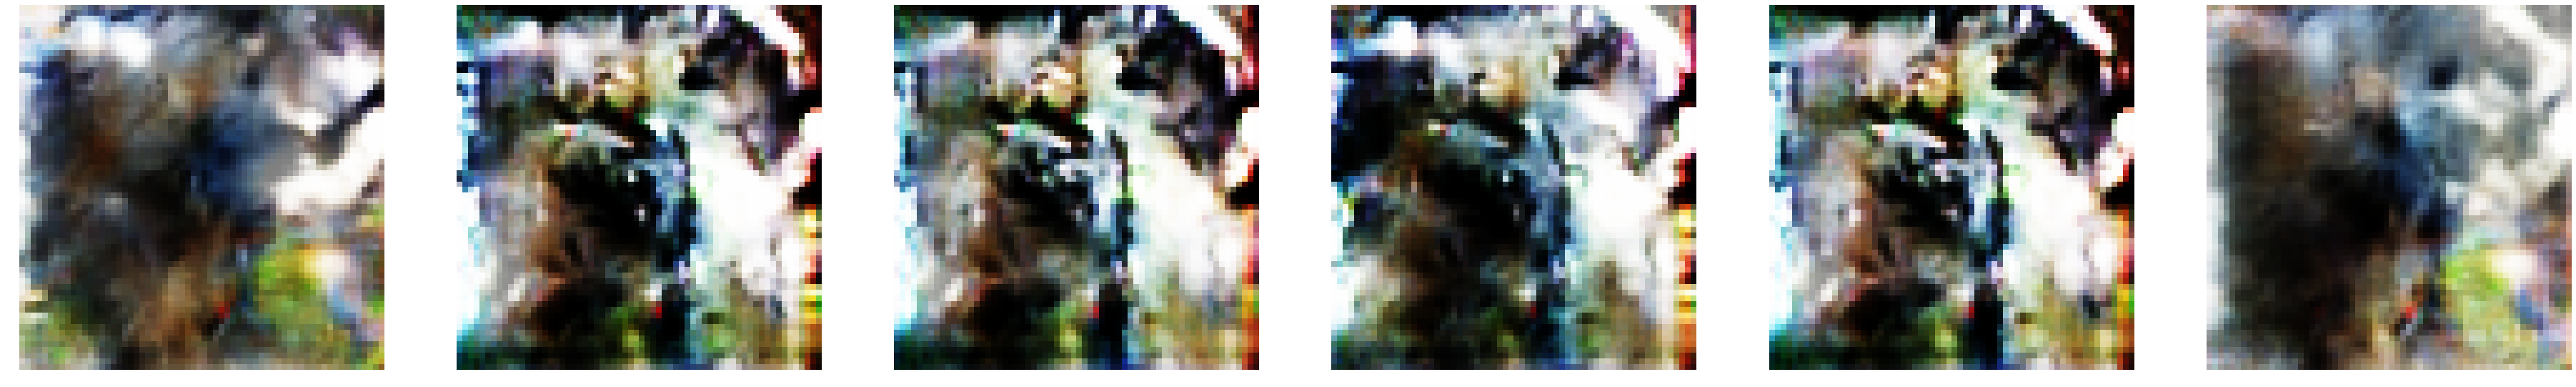

loss=rals 1epochの中での平均値 
 59.01s [262/301] Loss_D: 0.0506 Loss_G: 3.0149 outputR: 0.1970 outputF: -0.6413 / -0.6646
  最後のバッチのloss等 
    59.01s [262/301] Loss_D: 0.0275 Loss_G: 3.2797 outputR: 0.1579 outputF: -0.7435 / -0.7725
loss=rals 1epochの中での平均値 
 59.04s [263/301] Loss_D: 0.0518 Loss_G: 3.0190 outputR: 0.2243 outputF: -0.6139 / -0.6380
  最後のバッチのloss等 
    59.04s [263/301] Loss_D: 0.0485 Loss_G: 2.8873 outputR: 0.2139 outputF: -0.5651 / -0.6246
loss=rals 1epochの中での平均値 
 58.93s [264/301] Loss_D: 0.0488 Loss_G: 3.0179 outputR: 0.2552 outputF: -0.5868 / -0.6067
  最後のバッチのloss等 
    58.93s [264/301] Loss_D: 0.0329 Loss_G: 3.2180 outputR: 0.3401 outputF: -0.3886 / -0.5600
loss=rals 1epochの中での平均値 
 59.08s [265/301] Loss_D: 0.0479 Loss_G: 3.0320 outputR: 0.3764 outputF: -0.4668 / -0.4896
  最後のバッチのloss等 
    59.08s [265/301] Loss_D: 0.0043 Loss_G: 3.2596 outputR: 0.2044 outputF: -0.6708 / -0.7068
loss=rals 1epochの中での平均値 
 58.95s [266/301] Loss_D: 0.0482 Loss_G: 3.0312 outputR: 0.3229 outputF

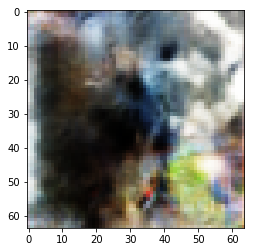

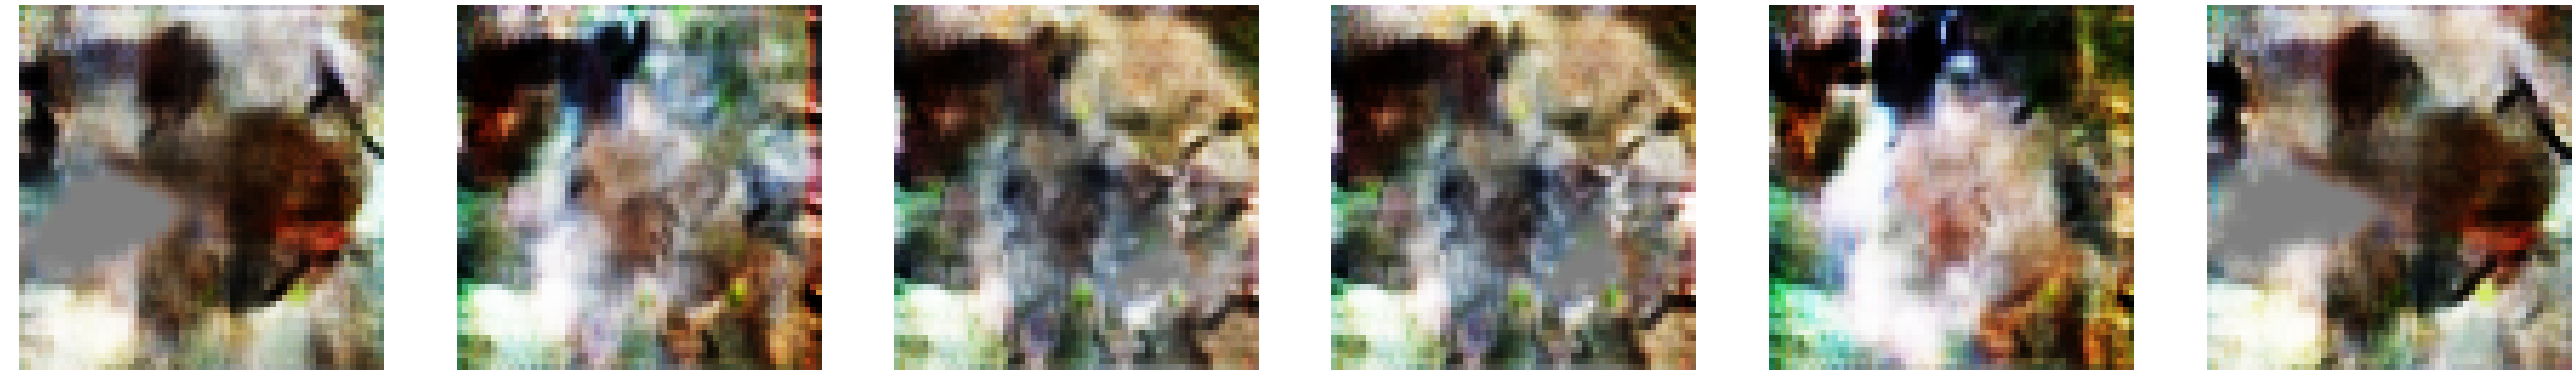

loss=rals 1epochの中での平均値 
 58.46s [272/301] Loss_D: 0.0459 Loss_G: 3.0043 outputR: 0.2883 outputF: -0.5543 / -0.5701
  最後のバッチのloss等 
    58.46s [272/301] Loss_D: 0.0267 Loss_G: 3.0667 outputR: 0.3148 outputF: -0.5172 / -0.5554
loss=rals 1epochの中での平均値 
 58.73s [273/301] Loss_D: 0.0469 Loss_G: 3.0118 outputR: 0.3790 outputF: -0.4640 / -0.4821
  最後のバッチのloss等 
    58.73s [273/301] Loss_D: 0.0756 Loss_G: 2.8340 outputR: 0.4599 outputF: -0.2541 / -0.3749
loss=rals 1epochの中での平均値 
 58.52s [274/301] Loss_D: 0.0479 Loss_G: 3.0054 outputR: 0.2637 outputF: -0.5769 / -0.5961
  最後のバッチのloss等 
    58.52s [274/301] Loss_D: 0.0423 Loss_G: 3.0472 outputR: 0.3911 outputF: -0.5149 / -0.4942
loss=rals 1epochの中での平均値 
 58.42s [275/301] Loss_D: 0.0473 Loss_G: 3.0141 outputR: 0.2229 outputF: -0.6190 / -0.6388
  最後のバッチのloss等 
    58.42s [275/301] Loss_D: 0.0782 Loss_G: 3.2130 outputR: 0.4086 outputF: -0.5743 / -0.5433
loss=rals 1epochの中での平均値 
 58.61s [276/301] Loss_D: 0.0457 Loss_G: 3.0246 outputR: 0.3413 outputF

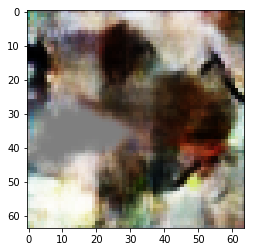

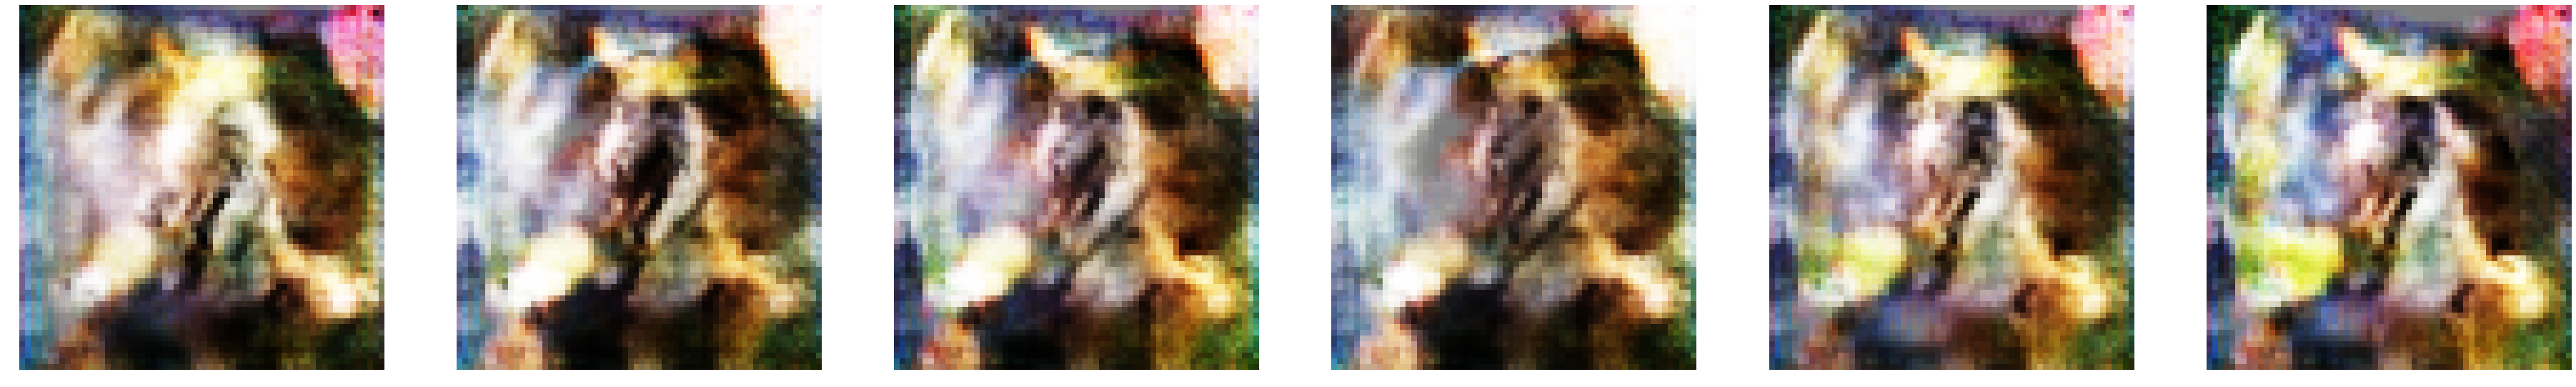

loss=rals 1epochの中での平均値 
 58.50s [282/301] Loss_D: 0.0464 Loss_G: 3.0434 outputR: 0.2586 outputF: -0.5847 / -0.6103
  最後のバッチのloss等 
    58.50s [282/301] Loss_D: 0.0584 Loss_G: 2.9696 outputR: 0.0310 outputF: -0.8364 / -0.8441
loss=rals 1epochの中での平均値 
 58.65s [283/301] Loss_D: 0.0469 Loss_G: 3.0277 outputR: 0.2842 outputF: -0.5599 / -0.5816
  最後のバッチのloss等 
    58.65s [283/301] Loss_D: 0.0193 Loss_G: 3.0356 outputR: 0.4060 outputF: -0.4491 / -0.4487
loss=rals 1epochの中での平均値 
 58.90s [284/301] Loss_D: 0.0457 Loss_G: 3.0159 outputR: 0.3492 outputF: -0.4954 / -0.5139
  最後のバッチのloss等 
    58.90s [284/301] Loss_D: 0.0029 Loss_G: 3.3491 outputR: 0.4259 outputF: -0.4821 / -0.5001
loss=rals 1epochの中での平均値 
 58.53s [285/301] Loss_D: 0.0455 Loss_G: 3.0297 outputR: 0.3079 outputF: -0.5369 / -0.5580
  最後のバッチのloss等 
    58.53s [285/301] Loss_D: 0.0611 Loss_G: 3.1616 outputR: 0.4430 outputF: -0.5420 / -0.4630
loss=rals 1epochの中での平均値 
 58.81s [286/301] Loss_D: 0.0424 Loss_G: 3.0099 outputR: 0.3567 outputF

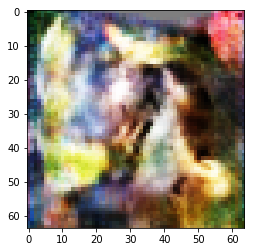

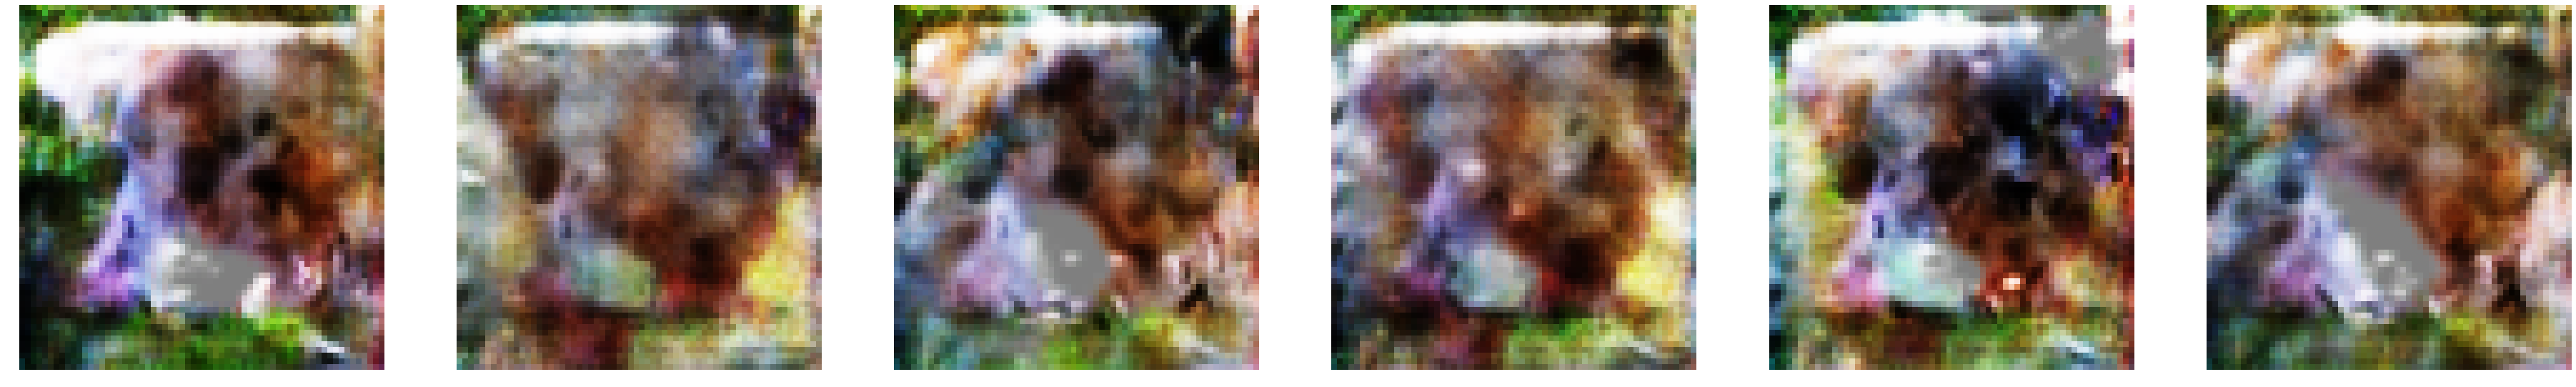

loss=rals 1epochの中での平均値 
 58.67s [292/301] Loss_D: 0.0471 Loss_G: 3.0009 outputR: 0.3826 outputF: -0.4588 / -0.4761
  最後のバッチのloss等 
    58.67s [292/301] Loss_D: 0.0704 Loss_G: 2.4056 outputR: 0.2328 outputF: -0.4690 / -0.4717
loss=rals 1epochの中での平均値 
 58.48s [293/301] Loss_D: 0.0453 Loss_G: 3.0108 outputR: 0.4160 outputF: -0.4295 / -0.4461
  最後のバッチのloss等 
    58.48s [293/301] Loss_D: 0.0670 Loss_G: 3.1736 outputR: 0.4578 outputF: -0.4902 / -0.4808
loss=rals 1epochの中での平均値 
 58.88s [294/301] Loss_D: 0.0461 Loss_G: 3.0325 outputR: 0.4127 outputF: -0.4317 / -0.4538
  最後のバッチのloss等 
    58.88s [294/301] Loss_D: 0.0288 Loss_G: 2.7379 outputR: 0.1812 outputF: -0.5678 / -0.5649
loss=rals 1epochの中での平均値 
 58.54s [295/301] Loss_D: 0.0445 Loss_G: 3.0215 outputR: 0.4447 outputF: -0.4022 / -0.4203
  最後のバッチのloss等 
    58.54s [295/301] Loss_D: 0.0232 Loss_G: 3.1357 outputR: 0.3986 outputF: -0.4984 / -0.4913
loss=rals 1epochの中での平均値 
 58.62s [296/301] Loss_D: 0.0447 Loss_G: 3.0108 outputR: 0.4308 outputF

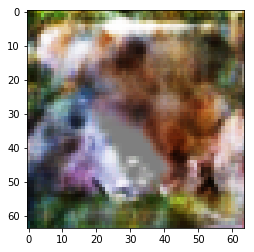

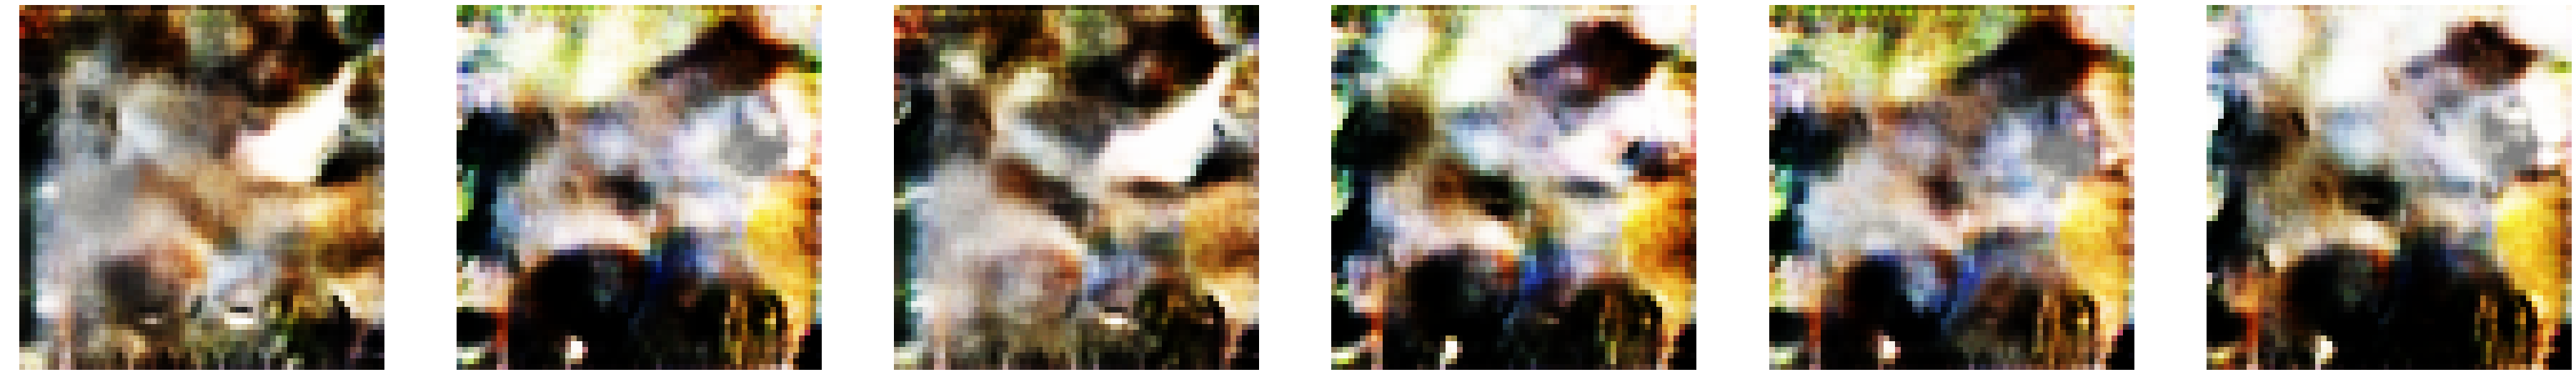

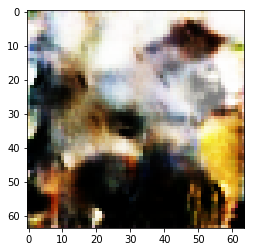

In [12]:
torch.backends.cudnn.benchmark = True

d_loss_log = []
g_loss_log = []
dout_real_log = []
dout_fake_log = []
dout_fake_log2 = []

iter_n = len(train_loader) - 1 #最後の余ったバッチは計算されないから-1

for epoch in range(epochs):
    
    epoch_g_loss = 0.0  # epochの損失和
    epoch_d_loss = 0.0  # epochの損失和
    epoch_dout_real = 0.0
    epoch_dout_fake = 0.0
    epoch_dout_fake2 = 0.0

    epoch_time = time.perf_counter()
    if time.perf_counter() - kernel_start_time > 31000:
            print("Time limit reached! Stopping kernel!"); break

    for ii, (real_images, dog_labels) in enumerate(train_loader):
        if real_images.shape[0]!= BATCH_SIZE: continue
        
        # ラベルにノイズを入れる。そして時々fakeとrealを入れ替える。
        if use_soft_noisy_labels:
            real_labels = torch.squeeze(torch.empty((BATCH_SIZE, 1), device=device).uniform_(0.85, 0.95))
            fake_labels = torch.squeeze(torch.empty((BATCH_SIZE, 1), device=device).uniform_(*F_uni))
            for p in np.random.choice(BATCH_SIZE, size=np.random.randint((BATCH_SIZE//8)), replace=False):
                real_labels[p], fake_labels[p] = fake_labels[p], real_labels[p] # swap labels
        else:
            real_labels = torch.full((BATCH_SIZE, 1), 1.0, device=device)
            fake_labels = torch.full((BATCH_SIZE, 1), 0.0, device=device)
        
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()

        dog_labels = torch.tensor(dog_labels, device=device)
        real_images = real_images.to(device)
        noise = torch.randn(BATCH_SIZE, nz, 1, 1, device=device)
        
        outputR = netD((real_images, dog_labels))
        fake_images = netG((noise, dog_labels))

        outputF = netD((fake_images.detach(), dog_labels))
        if loss_calc == 'rals':
            errD = (torch.mean((outputR - torch.mean(outputF) - real_labels) ** 2) + 
                    torch.mean((outputF - torch.mean(outputR) + real_labels) ** 2))/2
            
        elif loss_calc == 'hinge':
            d_loss_real = torch.nn.ReLU()(1.0 - (outputR - torch.mean(outputF))).mean()
            d_loss_fake = torch.nn.ReLU()(1.0 + (outputF - torch.mean(outputR))).mean()
            errD = (d_loss_real + d_loss_fake) / 2

        errD.backward(retain_graph=True)
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        noise = torch.randn(BATCH_SIZE, nz, 1, 1, device=device)
        fake_images = netG((noise, dog_labels))        
                                          
        outputF2 = netD((fake_images, dog_labels))
        if loss_calc == 'rals':
            errG = (torch.mean((outputR - torch.mean(outputF2) + real_labels) ** 2) +
                    torch.mean((outputF2 - torch.mean(outputR) - real_labels) ** 2)) / 2
        elif loss_calc == 'hinge':
            errG = (torch.mean(torch.nn.ReLU()(1.0 + (outputR - torch.mean(outputF2)))) + torch.mean(torch.nn.ReLU()(1.0 - (outputF2 - torch.mean(outputR)))))/2
            
        errG.backward()
        optimizerG.step()
        
        lr_schedulerG.step(epoch)
        lr_schedulerD.step(epoch)
        
        # --------------------
        # 3. 記録
        # --------------------
        epoch_d_loss += errD.item()
        epoch_g_loss += errG.item()
        epoch_dout_real += outputR.mean().item()
        epoch_dout_fake += outputF.mean().item()
        epoch_dout_fake2 += outputF2.mean().item()
        
    d_loss_log.append(epoch_d_loss/iter_n)
    g_loss_log.append(epoch_g_loss/iter_n)
    dout_real_log.append(epoch_dout_real/iter_n)
    dout_fake_log.append(epoch_dout_fake/iter_n)
    dout_fake_log2.append(epoch_dout_fake2/iter_n)
        
    if test_mode:
        print('loss=%s 1epochの中での平均値 \n %.2fs [%d/%d] Loss_D: %.4f Loss_G: %.4f outputR: %.4f outputF: %.4f / %.4f' % (loss_calc,
              time.perf_counter()-epoch_time, epoch+1, epochs, d_loss_log[-1], g_loss_log[-1],dout_real_log[-1], dout_fake_log[-1],dout_fake_log2[-1] ))
        print('  最後のバッチのloss等 \n    %.2fs [%d/%d] Loss_D: %.4f Loss_G: %.4f outputR: %.4f outputF: %.4f / %.4f' % (
            time.perf_counter()-epoch_time, epoch+1, epochs, errD.item(), errG.item(),outputR.mean().item(), outputF.mean().item(),outputF2.mean().item() ))
        if epoch > 3:
            if (d_loss_log[-2] < 1e-2) and (d_loss_log[-1] < 1e-2):
                notify(epoch)
                continue
                
    if epoch % 10 == 0:
        files = []
        img = show_generated_img(6)
        plt.imshow(img)
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        files.append({"imageFile": buf})
        message = 'base_gan_adam_ralsの訓練状況を伝えるよ。\n\n可愛いワンちゃん出来たかな？ \n [%d/%d] \nL_D: %.4f \nL_G: %.4f \noutR: %.4f \noutF: %.4f / %.4f' % (epoch+1, epochs, d_loss_log[-1], g_loss_log[-1],dout_real_log[-1], dout_fake_log[-1],dout_fake_log2[-1] )
        notify(message, files[0])     

## Visualise generated results by label and submit

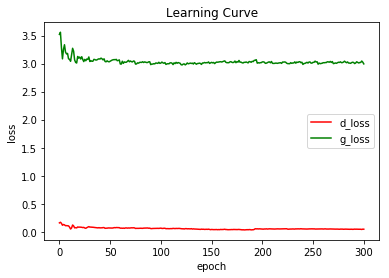

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("loss")

# Traing score と Test score をプロット
plt.plot(d_loss_log,   color="r", label="d_loss")
plt.plot(g_loss_log,   color="g", label="g_loss")

plt.legend(loc="best")

plt.show()

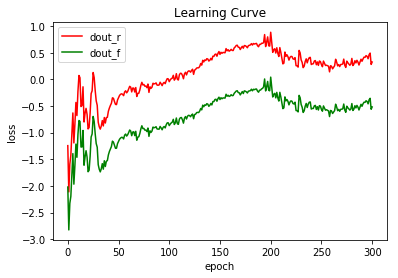

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("loss")

# Traing score と Test score をプロット
plt.plot(dout_real_log, color="r", label="dout_r")
plt.plot(dout_fake_log, color="g", label="dout_f")

plt.legend(loc="best")

plt.show()